Here, I repeat the hierarchical modeling exercise with principal components of Rrs having undergone some transformations (See DataPrep-5 notebook)

In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import rgb2hex
from matplotlib import rcParams
from seaborn import kdeplot
import cmocean.cm as cmo
import pymc3 as pm
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import re
import pickle

In [421]:
% matplotlib inline

In [422]:
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.titlesize'] = 20
rcParams['font.size'] = 16

In [423]:
def modified_forest_plot(trace, varnames, group_idcs, figsize=None):
    """
        Makes a modified series plot from trace, given variable names.
        expects pandas series of group indices
    """
    n_vars = len(varnames)
    if figsize is None:
        figsize = (max(5*n_vars, 12), 20)
    f, ax = pl.subplots(ncols=n_vars, figsize=figsize, sharey=True)
    n_chains = trace.nchains
    if isinstance(ax, np.ndarray):
        axs = ax.ravel()
    else:
        axs = np.array([ax]).ravel()    
    for axi, var in zip(axs, varnames):
        first_axis = True
        var_trace = trace[var]
        chain_length = int(var_trace.shape[0] / n_chains)
        n_provs = var_trace.shape[1]
        start_idx = 0
        alpha=0.05
        iqr=0.5
        chain_separation = 0.1
        axi.axvline(linestyle='--', zorder=0)
        if first_axis:
            axi.set_ylim(n_provs+1, 0)
            axi.set_yticks([i for i in range(1, n_provs+1)])
            axi.set_yticklabels(['%s (%d)' %(prov_mapping[i], (group_idcs==i).sum())
                                 for i in range(n_provs)])
            first_axis = False
        chain_ys = np.array([chain_separation * i for i in range(1, n_chains+1)])
        for provi in range(n_provs):
            chain_ys_provi = chain_ys - (n_chains * chain_separation)/2 - 0.05 + provi+1
            for chain_idx in range(0, n_chains):
                start_idx = chain_idx * chain_length
                end_idx = (chain_idx+1) * chain_length
                chain = var_trace[start_idx: end_idx, provi]
                chain_mean = chain.mean()
                chain_ci_alpha = pm.hpd(chain, alpha=alpha)
                chain_iqr = pm.hpd(chain, alpha=iqr)
                chain_yi = chain_ys_provi[chain_idx]
                axi.hlines(chain_yi, xmin=chain_ci_alpha[0], xmax=chain_ci_alpha[1],
                           linewidth=0.5)
                axi.hlines(chain_yi, xmin=chain_iqr[0], xmax=chain_iqr[1], linewidth=3);
                axi.scatter(chain_mean, chain_yi, s=30, color='k')
        axi.set_title(var)
        axi.grid(axis='y', linestyle='-.', color='gray')
    f.subplots_adjust(wspace=0.025)
    f.tight_layout();

## <u>Modeling PCs from Band-Normalized Rrs Data</u>

In [424]:
# load data with PCs from band-normalized rrs data
df_pca_bn = pd.read_pickle('./pickleJar/df_with_pca_from_band_normed_&_stdizded_rrs.pkl')

In [425]:
df_pca_bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311 entries, 0 to 3310
Data columns (total 23 columns):
id          3311 non-null object
datetime    3311 non-null datetime64[ns]
doy         3311 non-null float64
ProvCode    3311 non-null object
Province    3311 non-null object
ProvIdx     3311 non-null int8
etopo2      3311 non-null float64
oisst       3311 non-null float64
rrs411      3311 non-null float64
rrs443      3311 non-null float64
rrs489      3311 non-null float64
rrs510      3311 non-null float64
rrs555      3311 non-null float64
rrs670      3311 non-null float64
PC1         3311 non-null float64
PC2         3311 non-null float64
PC3         3311 non-null float64
PC4         3311 non-null float64
PC5         3311 non-null float64
PC6         3311 non-null float64
is_hplc     3311 non-null float64
chl         3311 non-null float64
chl_l       3311 non-null float64
dtypes: datetime64[ns](1), float64(18), int8(1), object(3)
memory usage: 572.4+ KB


In [5]:
df_pca_bn.describe().T

count          mean           std           min           25%  \
doy      3311.0  1.572167e+02  1.019157e+02  2.850000e+00  5.986250e+01   
ProvIdx  3311.0  1.787526e+01  1.286243e+01  0.000000e+00  4.000000e+00   
etopo2   3311.0  1.258261e+03  1.765799e+03  0.000000e+00  1.600000e+01   
oisst    3311.0  1.517149e+01  1.029574e+01 -1.800000e+00  2.175000e+00   
rrs411   3311.0  2.190789e-01  8.568647e-02  8.452344e-03  1.553010e-01   
rrs443   3311.0  2.053904e-01  5.996617e-02  4.227509e-02  1.603905e-01   
rrs489   3311.0  2.088197e-01  2.577455e-02  9.676770e-02  1.949811e-01   
rrs510   3311.0  1.805565e-01  3.756347e-02  6.549416e-02  1.538404e-01   
rrs555   3311.0  1.531706e-01  8.903286e-02  2.863814e-02  7.718100e-02   
rrs670   3311.0  3.298382e-02  4.498779e-02  0.000000e+00  4.994493e-03   
PC1      3311.0 -8.584026e-18  1.435183e-01 -2.643705e-01 -1.191551e-01   
PC2      3311.0 -6.974521e-18  4.014638e-02 -1.252293e-01 -2.684366e-02   
PC3      3311.0 -8.449900e-18  2.260476e-02 -1.111474e-01 -1.071395e-02   
PC4      3311.0  1.535736e-17  1.337030e-02 -6.037854e-02 -7.630189e-03   
PC5      3311.0 -1.643036e-17  8.075865e-03 -4.758442e-02 -4.986903e-03   
PC6      3311.0  1.681223e-17  3.771455e-17 -2.682333e-16 -8.498835e-18   
is_hplc  3311.0  3.515554e-01  4.775281e-01  0.000000e+00  0.000000e+00   
chl      3311.0  2.979196e+00  6.274630e+00  1.200000e-02  2.283000e-01   
chl_l    3311.0 -9.420714e-02  7.137449e-01 -1.920819e+00 -6.414945e-01   

                  50%           75%           max  
doy      1.494750e+02  2.436458e+02  3.654500e+02  
ProvIdx  1.200000e+01  2.900000e+01  4.400000e+01  
etopo2   2.270000e+02  2.640500e+03  7.978000e+03  
oisst    1.667000e+01  2.457500e+01  3.089000e+01  
rrs411   2.239427e-01  2.846105e-01  4.319637e-01  
rrs443   2.106018e-01  2.547298e-01  3.428738e-01  
rrs489   2.143413e-01  2.263464e-01  2.889360e-01  
rrs510   1.893405e-01  2.078754e-01  2.977106e-01  
rrs555   1.325698e-01  2.211116e-01  4.235803e-01  
rrs670   1.210052e-02  3.973229e-02  4.094498e-01  
PC1     -1.744019e-02  1.085544e-01  3.656906e-01  
PC2     -5.284944e-03  2.571036e-02  2.347878e-01  
PC3      3.022702e-04  1.092424e-02  2.328571e-01  
PC4      4.127612e-04  7.745869e-03  7.866342e-02  
PC5      5.078385e-04  5.039931e-03  6.186012e-02  
PC6      1.647446e-17  4.222751e-17  4.396813e-16  
is_hplc  0.000000e+00  1.000000e+00  1.000000e+00  
chl      7.810000e-01  2.341000e+00  7.786480e+01  
chl_l   -1.073490e-01  3.694014e-01  1.891341e+00

In [426]:
# SOME ASSIGNMENTS FOR EASIER MANIPULATION
x_pc = df_pca_bn.filter(regex='PC').as_matrix()
log_chl_obs = df_pca_bn.chl_l.values
n_provinces = df_pca_bn.Province.unique().size
n_pc = x_pc.shape[1]
provIdx = df_pca_bn.ProvIdx.values
prov_mapping = dict(enumerate(df_pca_bn['Province'].astype('category').cat.categories))

In [437]:
# PREDICTOR STANDARDIZATION
stdizer_predictor = StandardScaler()
stdizer_predicted = StandardScaler()
x_pc_s = stdizer_predictor.fit_transform(x_pc).T
log_chl_obs_s = stdizer_predicted.fit_transform(log_chl_obs.reshape(-1,1))
x_pc_s.shape, log_chl_obs_s.shape

((6, 3311), (3311, 1))

#### PC1 as sole predictor

In [438]:
with pm.Model() as m1ve:
    "Varying slopes regression on PC1 only"
    # hyper-priors
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b = pm.Normal('mu_b', mu=0, sd=100)
    sig_b = pm.HalfCauchy('sig_b', 2.5)
    
    # prior
    #a = pm.Normal('a', mu=0, sd=10)
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    b1 = pm.Normal('b1', mu=mu_b, sd=sig_b, shape=n_provinces)
    mu_log_chl = pm.Deterministic('mu_log_chl',
                                  a_prov[provIdx] 
                                  + b1[provIdx] * x_pc_s[0] )
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    
    #step = pm.Metropolis()
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs_s)
    trace_m1ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b1, a_prov, sig_b_log__, mu_b, sig_a_log__, mu_a]
  0%|          | 5/10000 [00:08<4:59:11,  1.80s/it]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
  0%|          | 6/10000 [00:11<5:17:28,  1.91s/it]Exception in thread Thread-77:
Traceback (most recent call last):
  File "/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_wor

AttributeError: 'NoneType' object has no attribute 'terminate'

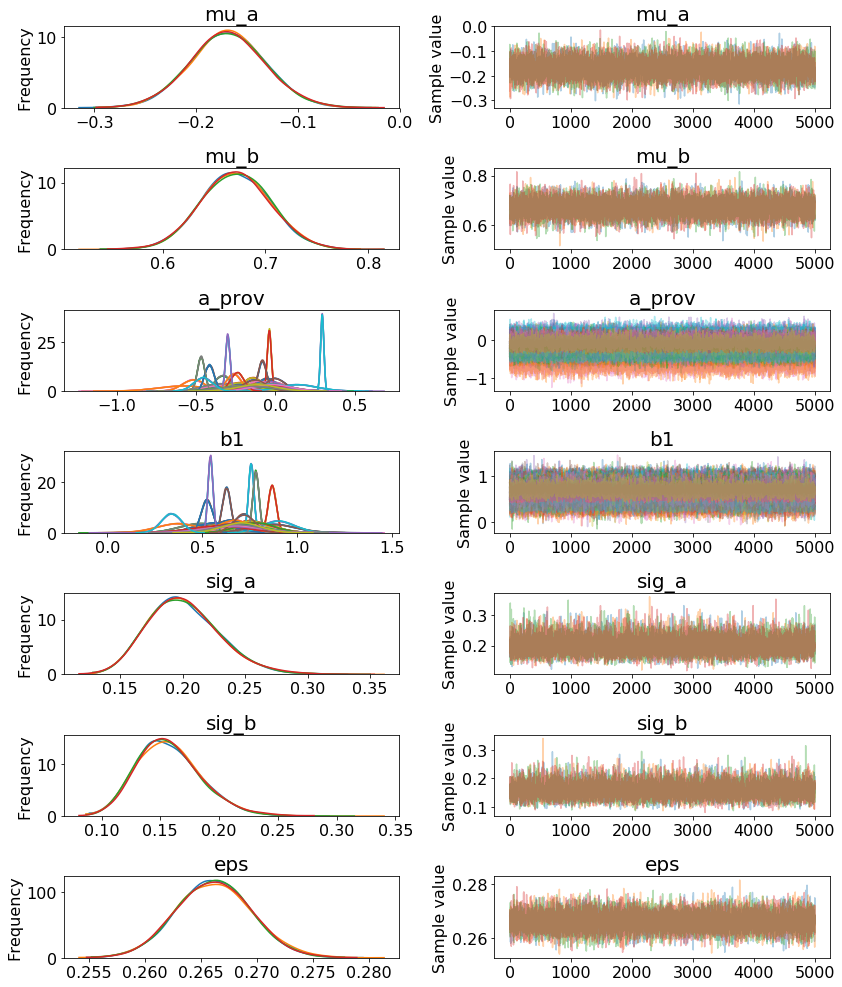

In [16]:
pm.traceplot(trace_m1ve);

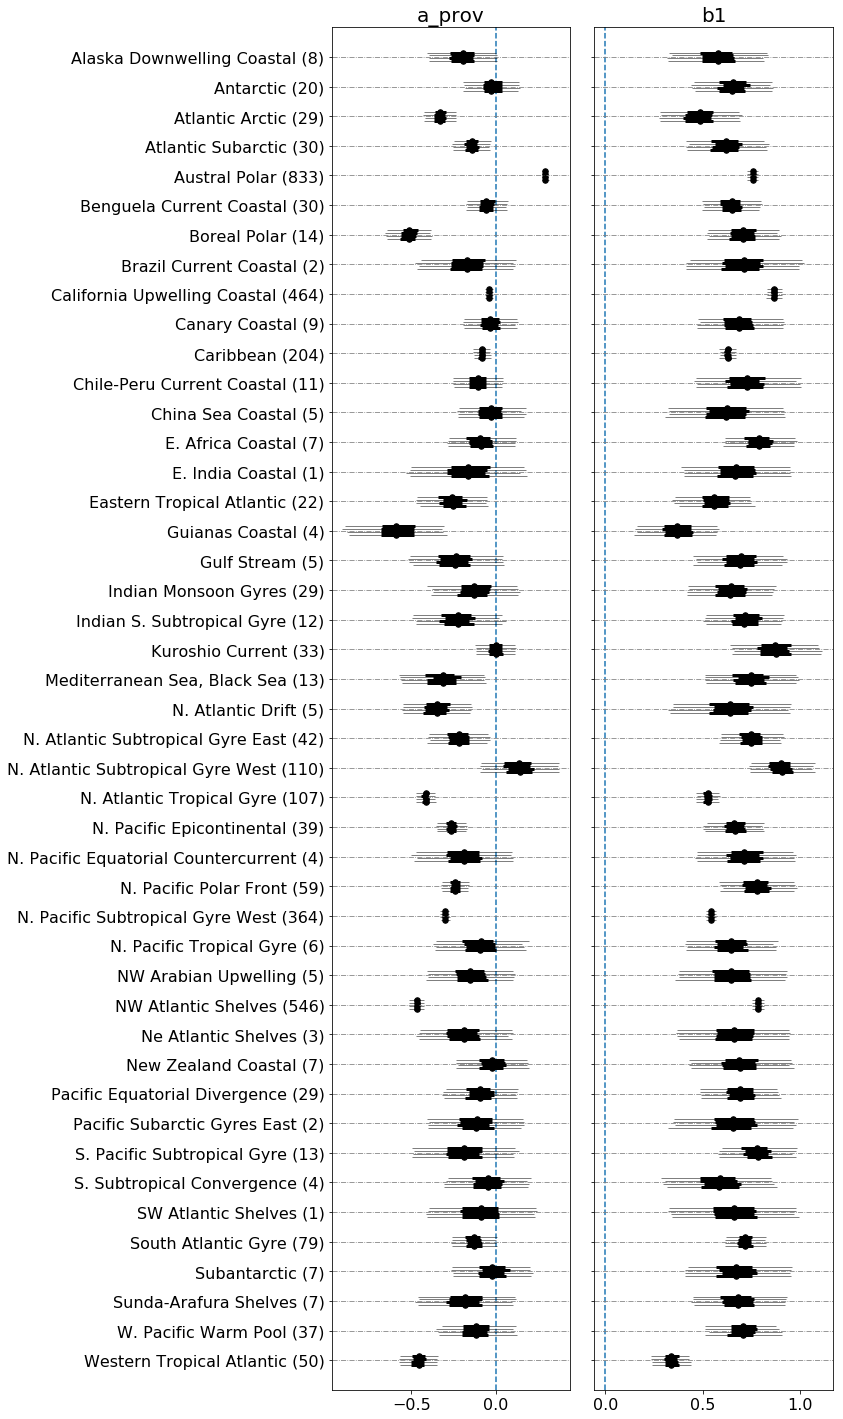

In [245]:
s_providx = df_pca_bn.ProvIdx
modified_forest_plot(trace_m1ve, varnames=['a_prov', 'b1'],
                     group_idcs=s_providx)

In [404]:
with pm.Model() as m2ve:
    "Varying slopes MLR on PC1 and PC2 only"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    mu_log_chl = pm.Deterministic('mu_log_chl', 
                                  a_prov[provIdx] 
                                  + b1[provIdx] * x_pc_s[0] \
                                  + b2[provIdx] * x_pc_s[1] )
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl, observed=log_chl_obs)
    trace_m2ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b2, b1, a_prov, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  3%|▎         | 300/10000 [00:09<05:21, 30.21it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [02:06<00:00, 78.85it/s]


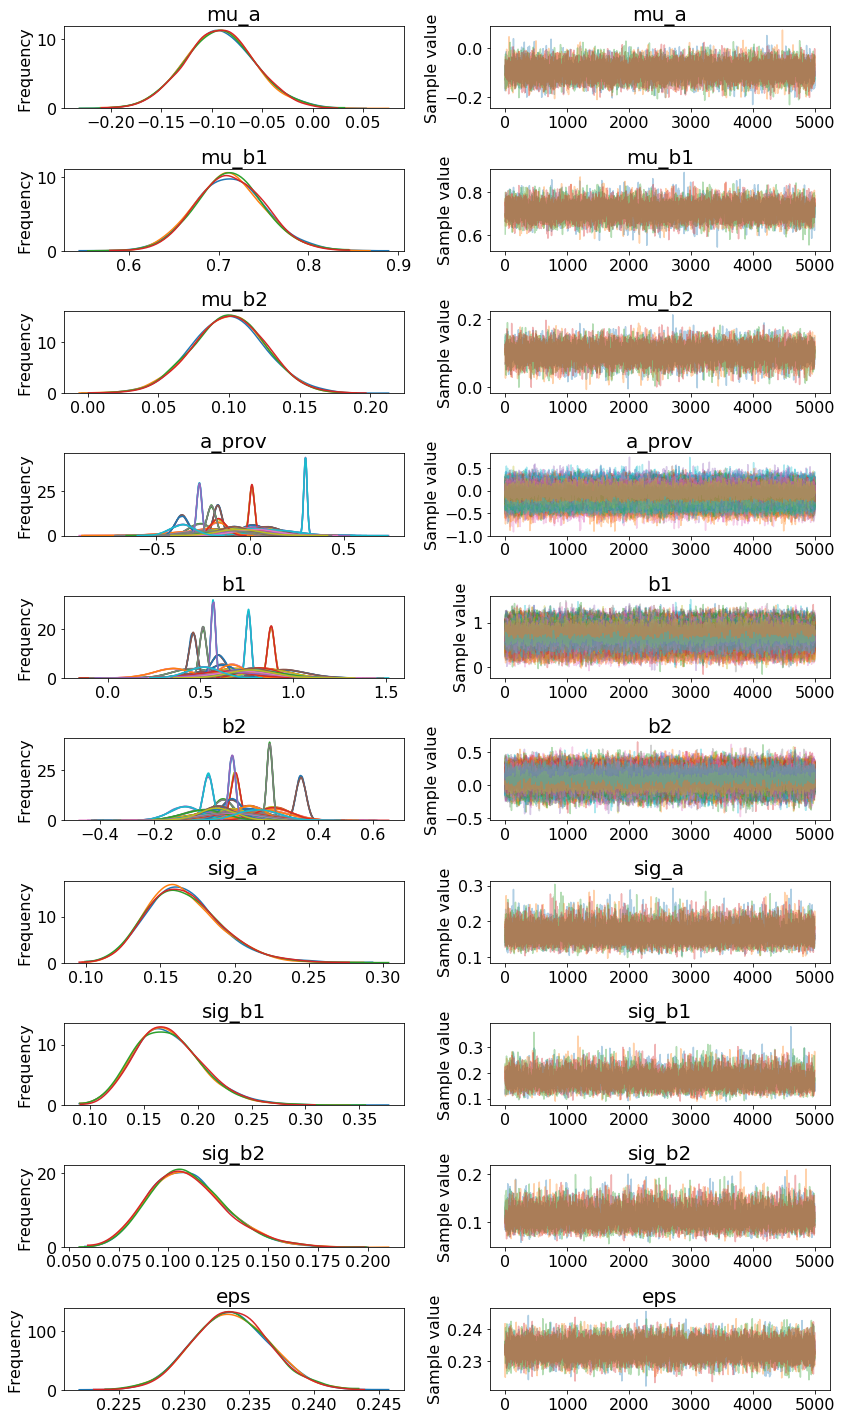

In [241]:
pm.traceplot(trace_m2ve);

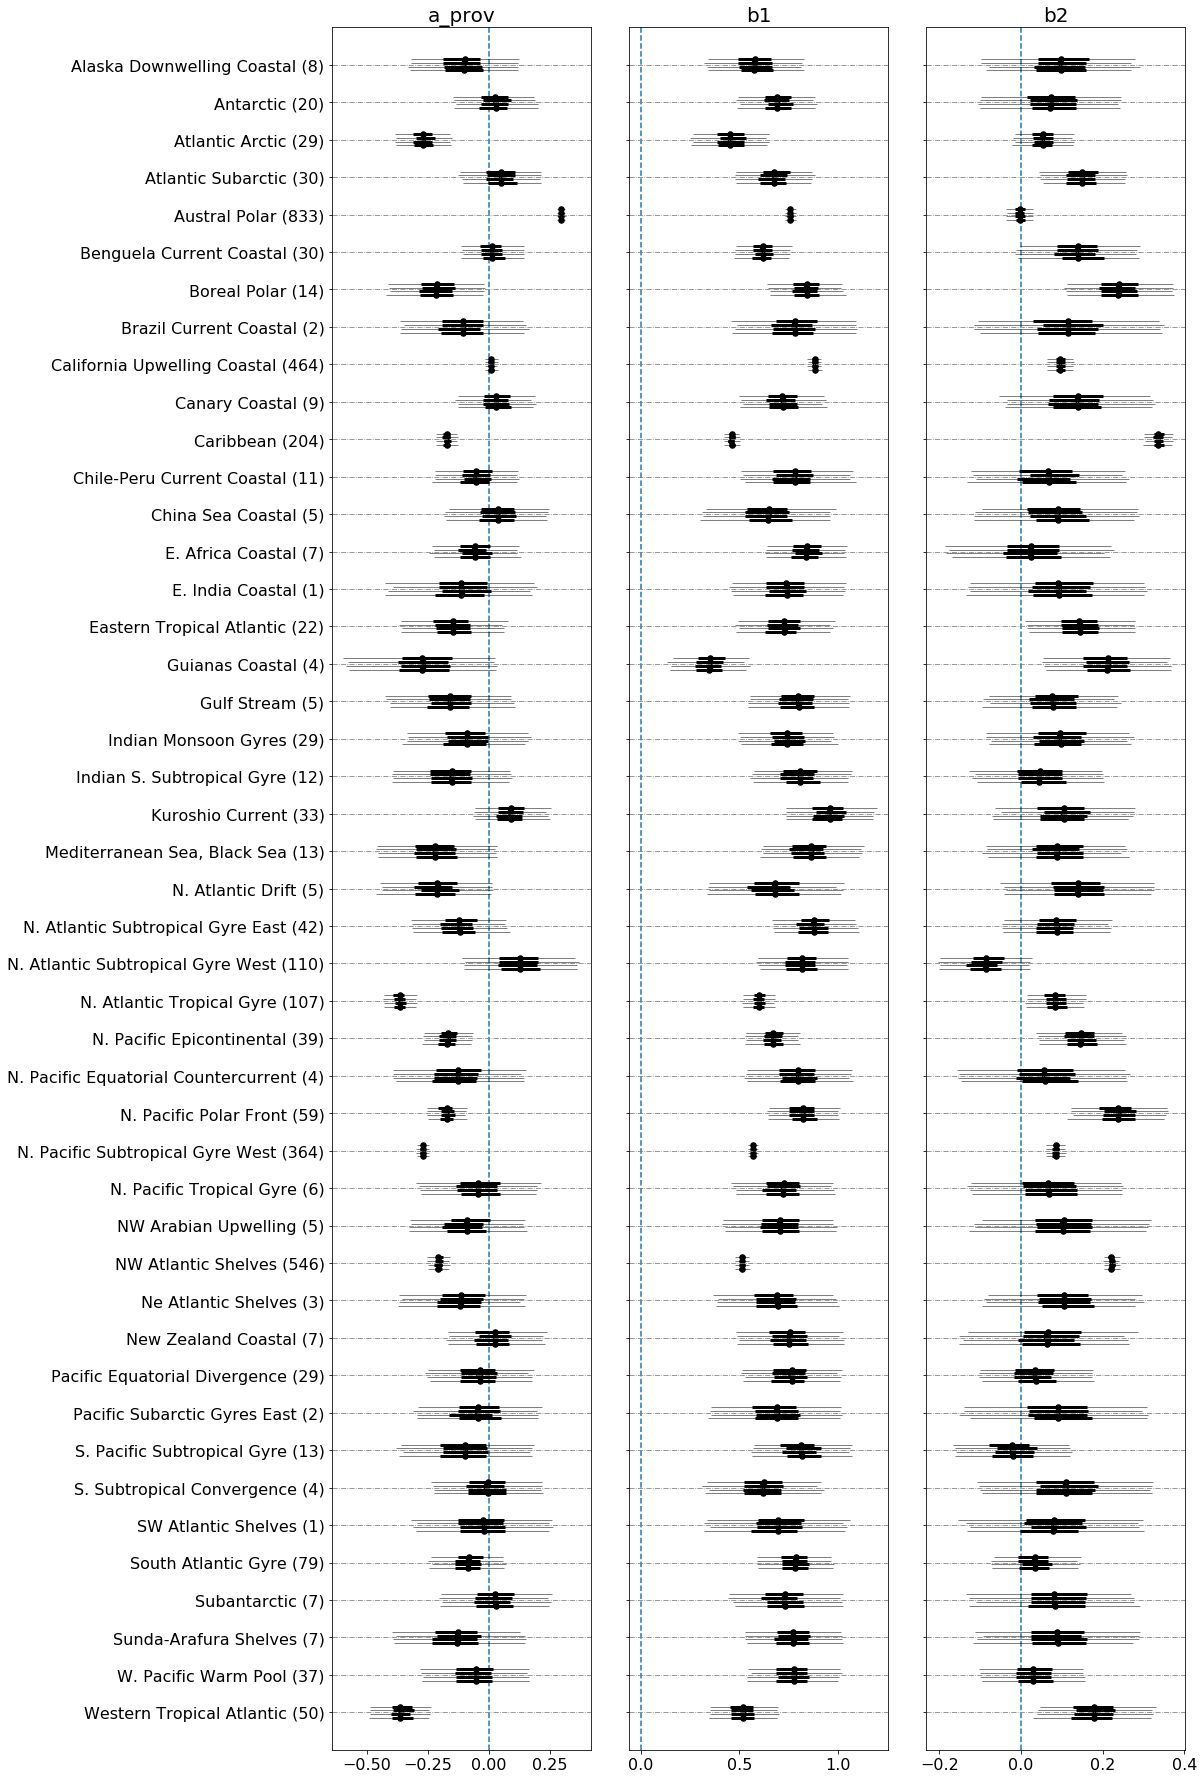

In [246]:
modified_forest_plot(trace_m2ve, varnames=['a_prov', 'b1', 'b2'],
                     group_idcs=s_providx, figsize=(17, 25))

In [412]:
with pm.Model() as m3ve:
    "Varying slopes MLR on PC1 and PC2 only"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    mu_b3 = pm.Normal('mu_b3', mu=0, sd=100)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    
    a_offset = pm.Normal('a_offset', mu=0, sd=10, shape=n_provinces)
    b_offsets = pm.Normal('b_offsets', mu=0, sd=10, shape=(3, n_provinces))
    a_prov = pm.Deterministic('a_prov', mu_a + a_offset * sig_a)
    b1 = pm.Deterministic('b1', mu_b1 + b_offsets[0, :] * sig_b1)
    b2 = pm.Deterministic('b2', mu_b2 + b_offsets[1,:] * sig_b2)
    b3 = pm.Deterministic('b3', mu_b3 + b_offsets[2, :] * sig_b3)
    
    #a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    #b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    #b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    #b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    mu_log_chl = pm.Deterministic('mu_log_chl', 
                                 a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] )
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m3ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_offsets, a_offset, sig_b3_log__, mu_b3, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  1%|          | 98/10000 [00:09<16:43,  9.86it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [04:44<00:00, 35.21it/s]


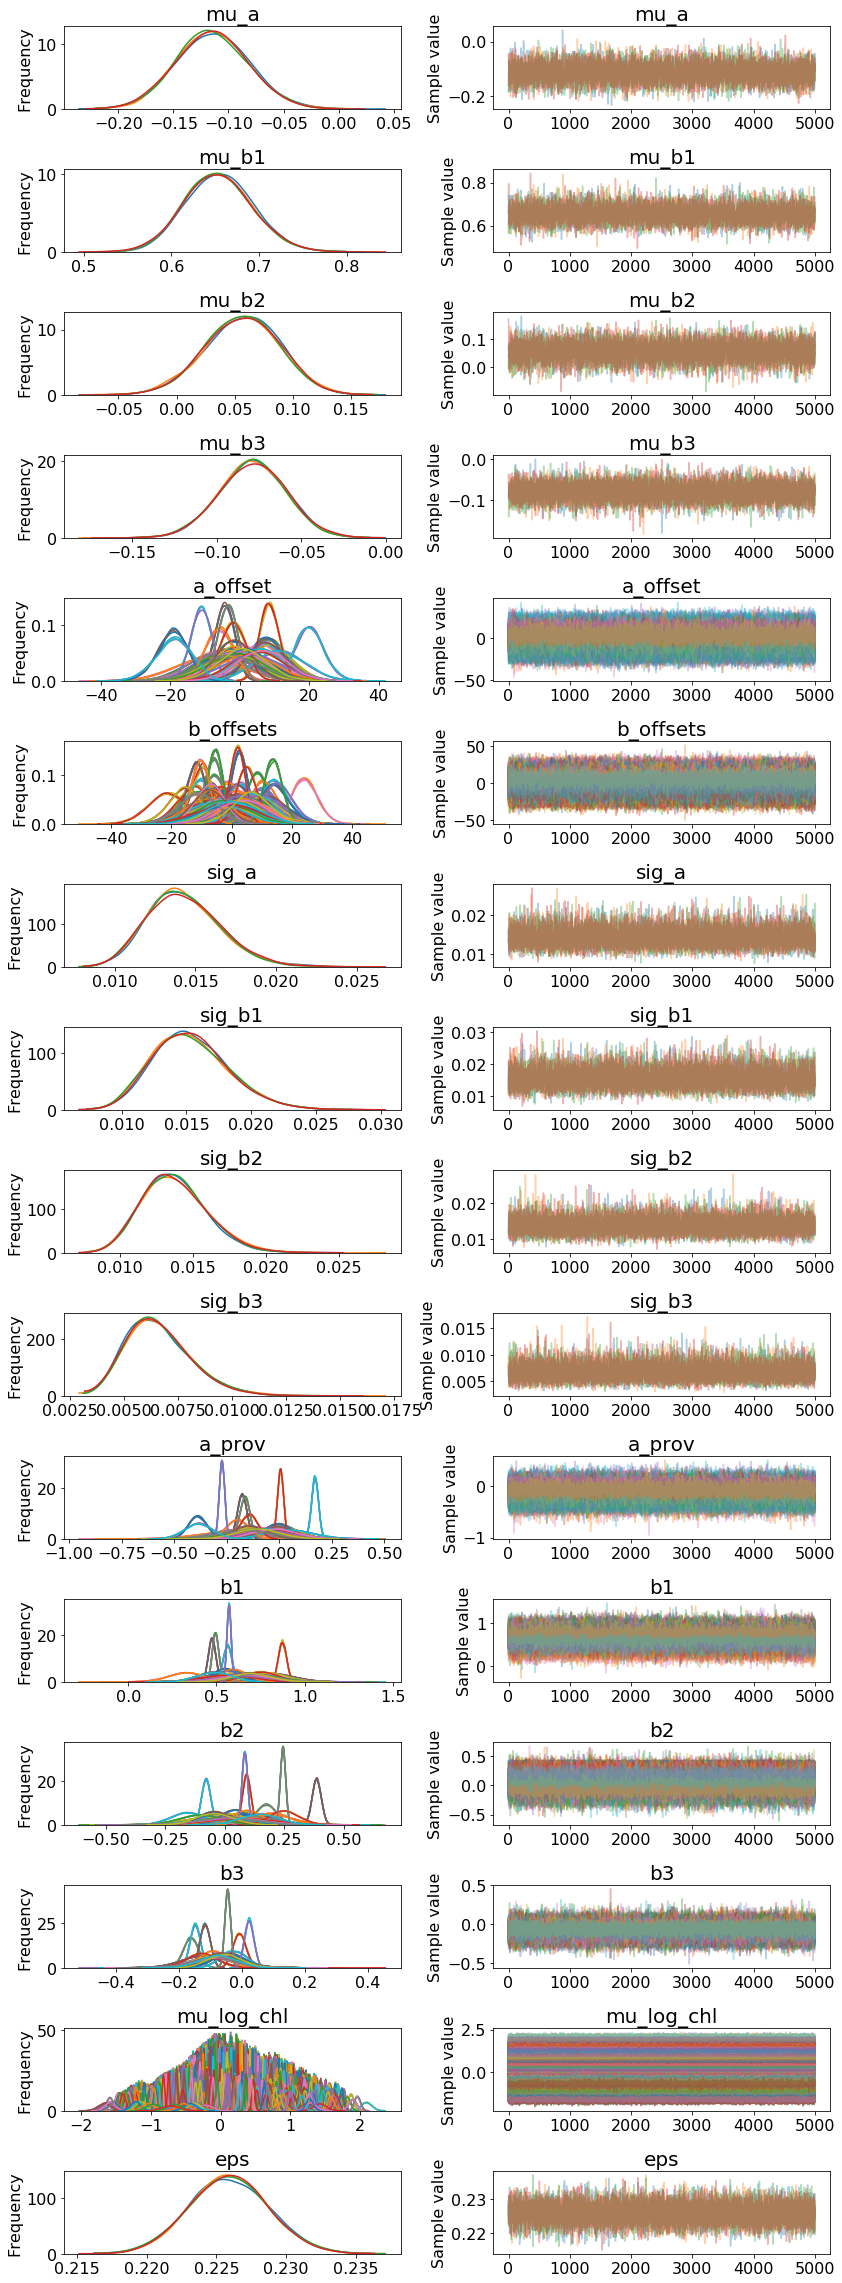

In [413]:
pm.traceplot(trace_m3ve);

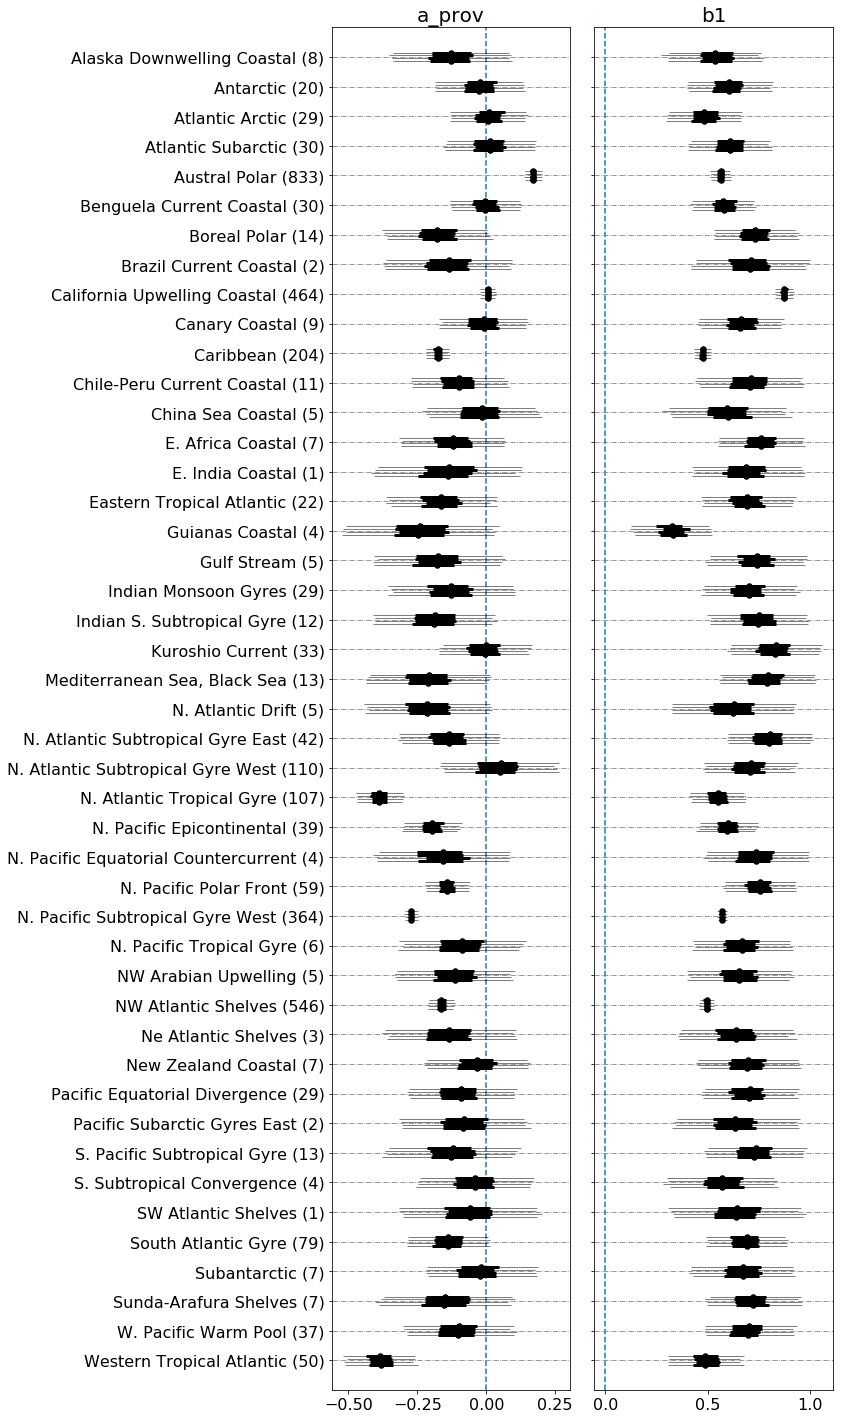

In [414]:
modified_forest_plot(trace_m3ve, ['a_prov', 'b1'], s_providx)

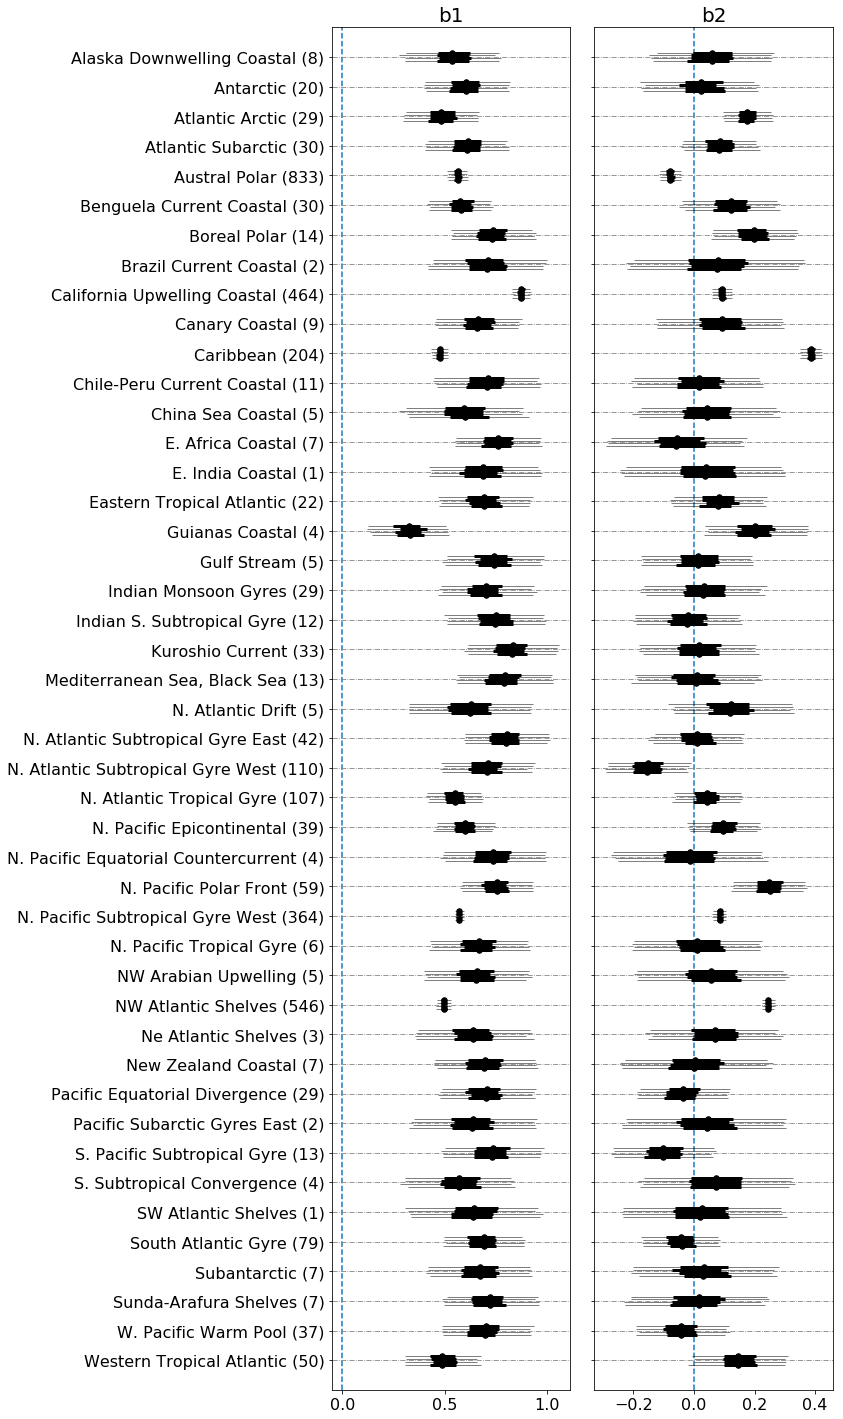

In [415]:
modified_forest_plot(trace_m3ve, ['b1', 'b2'], s_providx)

In [406]:
with pm.Model() as m4ve:
    "Varying slopes MLR on PC1...4 only"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    mu_b3 = pm.Normal('mu_b3', mu=0, sd=100)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    mu_b4 = pm.Normal('mu_b4', mu=0, sd=100)
    sig_b4 = pm.HalfCauchy('sig_b4', 2.5)
    
    
    # begin -- NC segment
    a_offset = pm.Normal('a_offset', mu=0, sd=10, shape=n_provinces)
    b1_offset = pm.Normal('b1_offset', mu=0, sd=10, shape=n_provinces)
    b2_offset = pm.Normal('b2_offset', mu=0, sd=10, shape=n_provinces)
    b3_offset = pm.Normal('b3_offset', mu=0, sd=10, shape=n_provinces)
    b4_offset = pm.Normal('b4_offset', mu=0, sd=10, shape=n_provinces)
    
    a_prov = pm.Deterministic('a_prov', mu_a + a_offset * sig_a)
    b1 = pm.Deterministic('b1', mu_b1 + b1_offset * sig_b1)
    b2 = pm.Deterministic('b2', mu_b2 + b2_offset * sig_b2)
    b3 = pm.Deterministic('b3', mu_b3 + b3_offset * sig_b3)
    b4 = pm.Deterministic('b4', mu_b4 + b4_offset * sig_b4)
    # end -- NC segment
    # the below was commented out in favor of the NC segment above because of 
    # too few effective parameters.
    #a_prov = pm.Normal('a', mu=mu_a, sd=sig_a, shape=n_provinces)
    #b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    #b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    #b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    #b4 = pm.Normal('b4', mu=mu_b4, sd=sig_b4, shape=n_provinces)
    mu_log_chl = pm.Deterministic('mu_log_chl', 
                                 a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] \
                                 + b4[provIdx] * x_pc_s[3] )
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m4ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b4_offset, b3_offset, b2_offset, b1_offset, a_offset, sig_b4_log__, mu_b4, sig_b3_log__, mu_b3, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  1%|          | 95/10000 [00:09<17:14,  9.58it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [05:28<00:00, 30.43it/s]


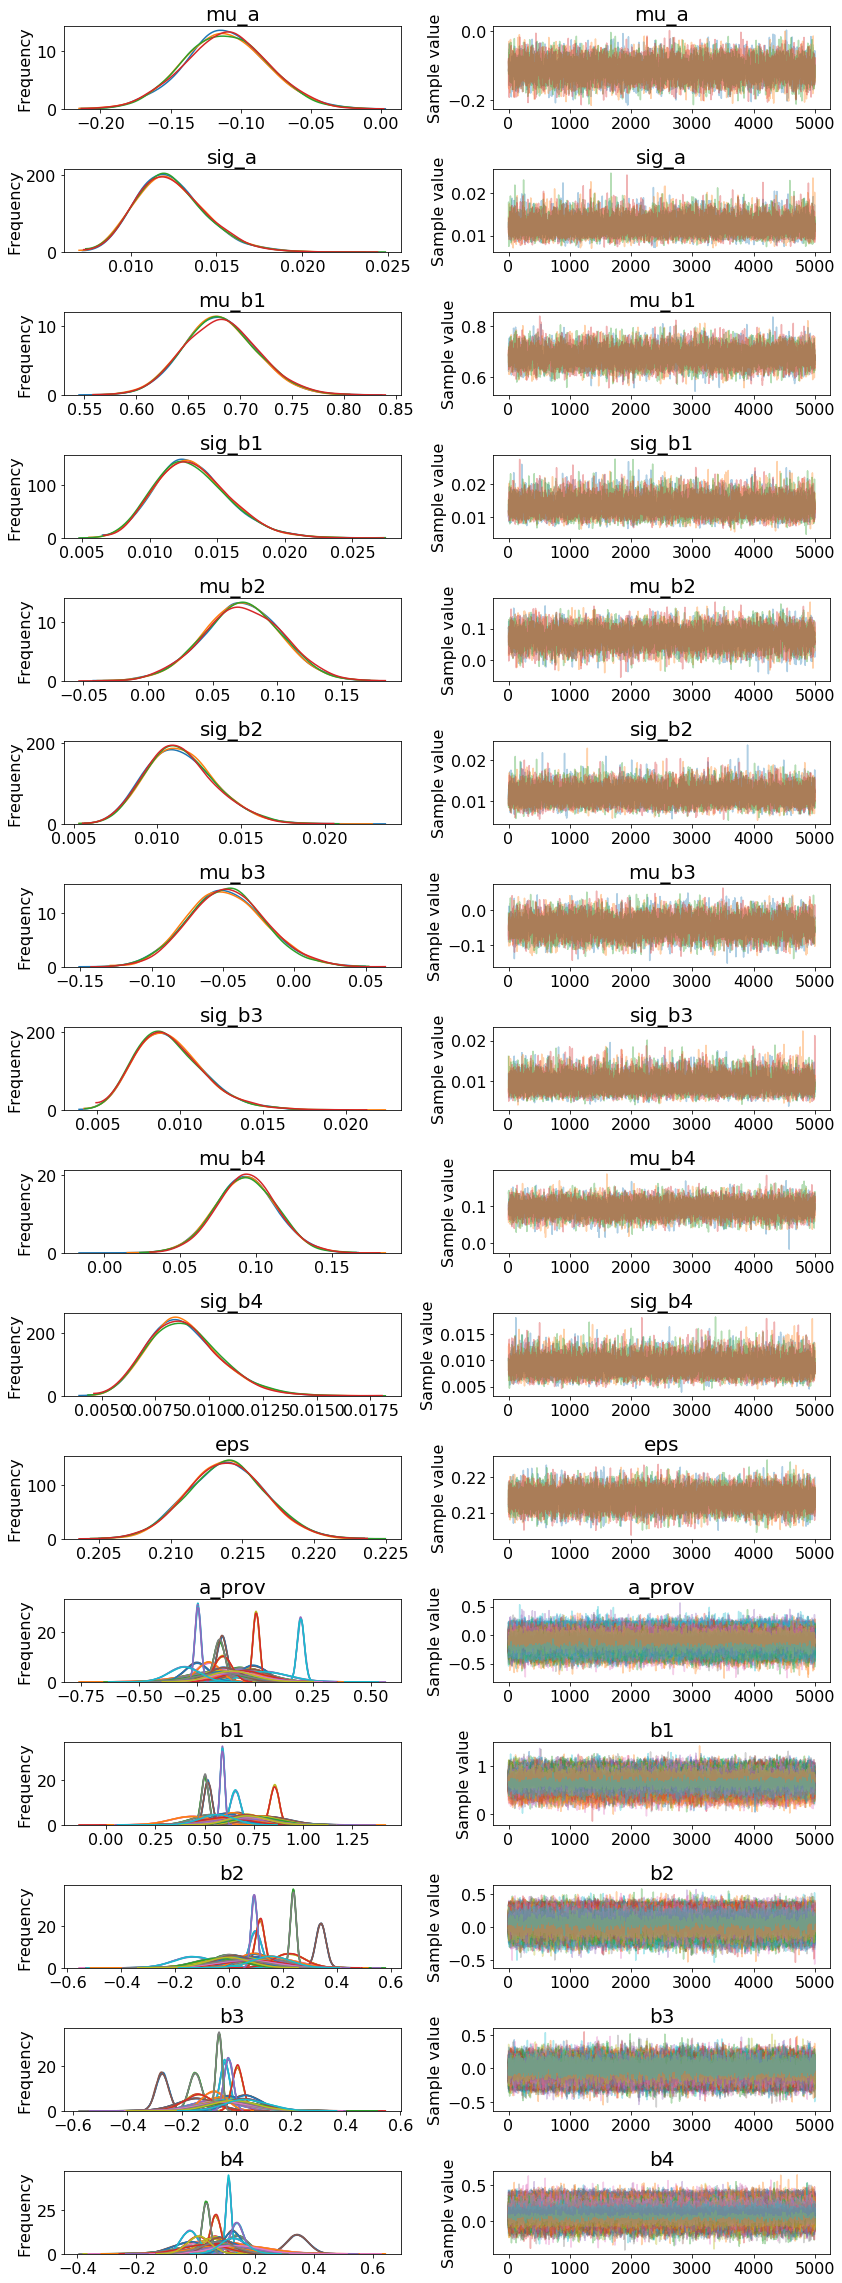

In [260]:
pm.traceplot(trace_m4ve, varnames=['mu_a', 'sig_a', 'mu_b1', 'sig_b1', 'mu_b2', 'sig_b2',
                                'mu_b3', 'sig_b3', 'mu_b4', 'sig_b4', 'eps',
                                'a_prov', 'b1', 'b2' ,'b3', 'b4']);

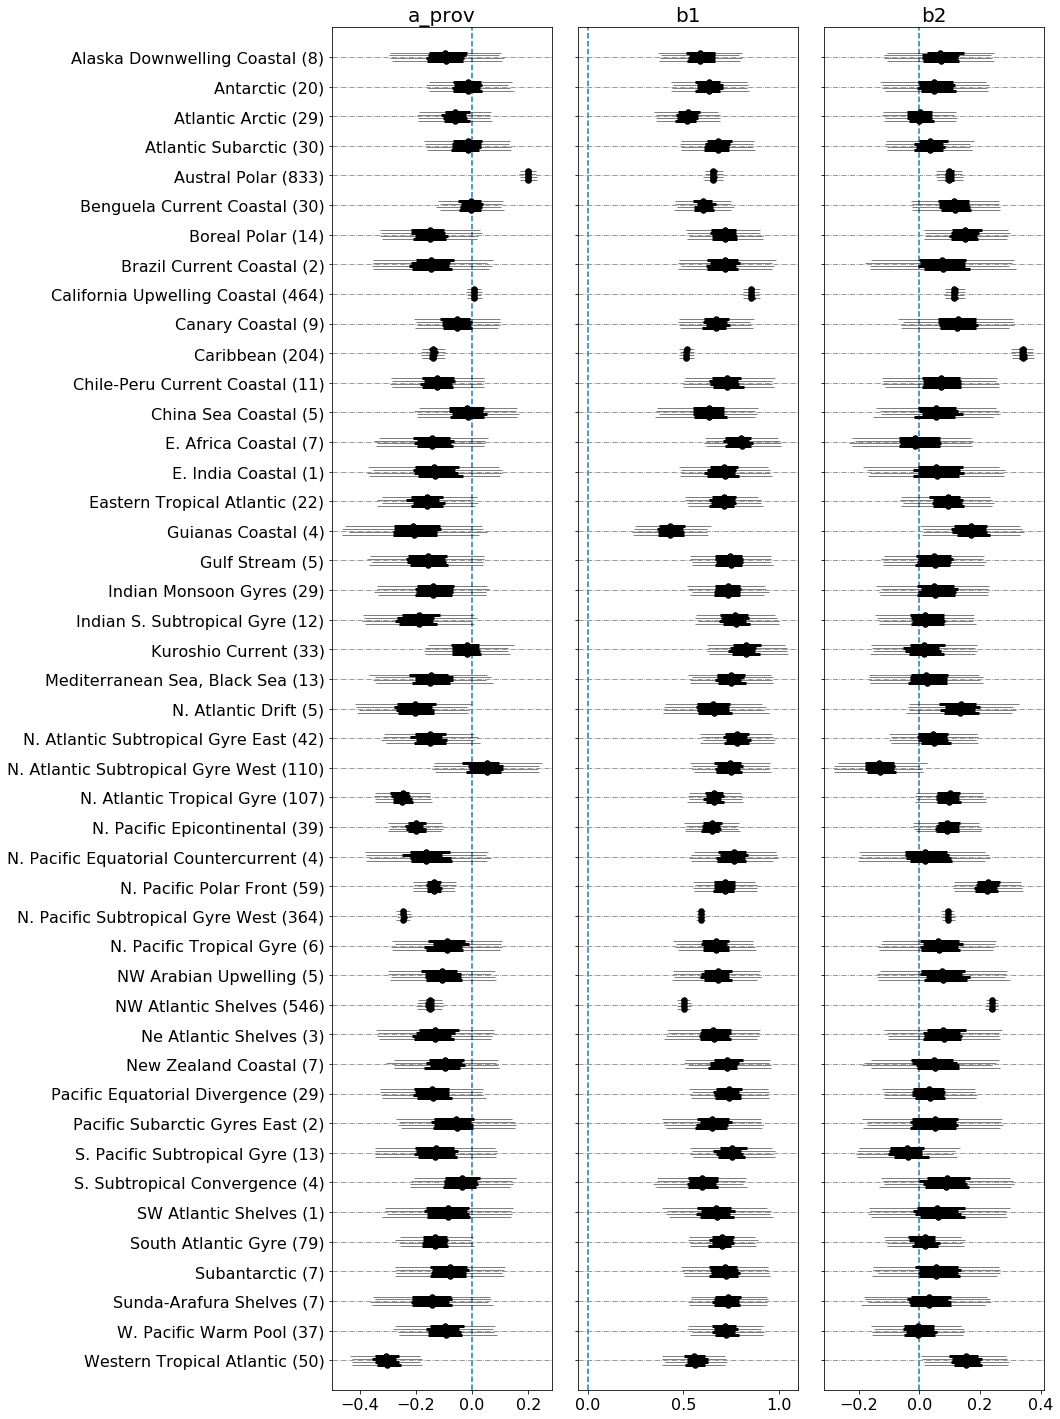

In [261]:
modified_forest_plot(trace_m4ve, ['a_prov', 'b1', 'b2'], s_providx)

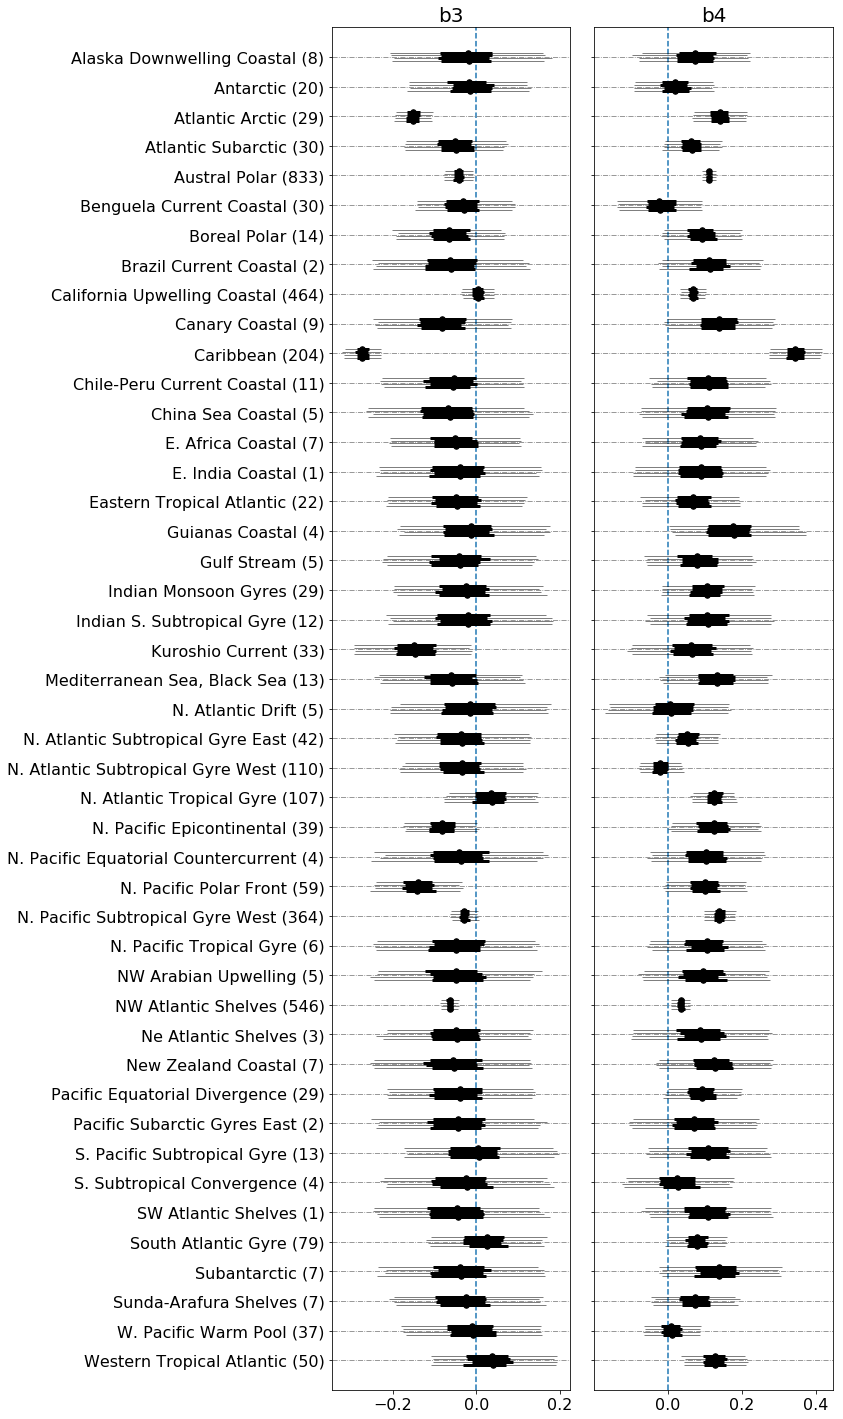

In [262]:
modified_forest_plot(trace_m4ve, ['b3', 'b4'], s_providx)

In [407]:
with pm.Model() as m5ve:
    "Varying slopes MLR on PC1... 5"
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    mu_b3 = pm.Normal('mu_b3', mu=0, sd=100)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    mu_b4 = pm.Normal('mu_b4', mu=0, sd=100)
    sig_b4 = pm.HalfCauchy('sig_b4', 2.5)
    mu_b5 = pm.Normal('mu_b5', mu=0, sd=100)
    sig_b5  =pm.HalfCauchy('sig_b5', 2.5)
    
    a_offset = pm.Normal('a_offset', mu=0, sd=10, shape=n_provinces)
    b1_offset = pm.Normal('b1_offset', mu=0, sd=10, shape=n_provinces)
    b2_offset = pm.Normal('b2_offset', mu=0, sd=10, shape=n_provinces)
    b3_offset = pm.Normal('b3_offset', mu=0, sd=10, shape=n_provinces)
    b4_offset = pm.Normal('b4_offset', mu=0, sd=10, shape=n_provinces)
    b5_offset = pm.Normal('b5_offset', mu=0, sd=10, shape=n_provinces)
    
    a_prov = pm.Deterministic('a_prov', mu_a + a_offset * sig_a)
    b1 = pm.Deterministic('b1', mu_b1 + b1_offset * sig_b1)
    b2 = pm.Deterministic('b2', mu_b2 + b2_offset * sig_b2)
    b3 = pm.Deterministic('b3', mu_b3 + b3_offset * sig_b3)
    b4 = pm.Deterministic('b4', mu_b4 + b4_offset * sig_b4)
    b5 = pm.Deterministic('b5', mu_b5 + b5_offset * sig_b5)
    
    #a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a, shape=n_provinces)
    #b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    #b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    #b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    #b4 = pm.Normal('b4', mu=mu_b4, sd=sig_b4, shape=n_provinces)
    #b5 = pm.Normal('b5', mu=mu_b5, sd=sig_b5, shape=n_provinces)
    mu_log_chl = pm.Deterministic('mu_log_chl',
                                 a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] \
                                 + b4[provIdx] * x_pc_s[3] \
                                 + b5[provIdx] * x_pc_s[4])
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m5ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b5_offset, b4_offset, b3_offset, b2_offset, b1_offset, a_offset, sig_b5_log__, mu_b5, sig_b4_log__, mu_b4, sig_b3_log__, mu_b3, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1, sig_a_log__, mu_a]
  1%|          | 78/10000 [00:09<20:58,  7.88it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [06:13<00:00, 26.76it/s]


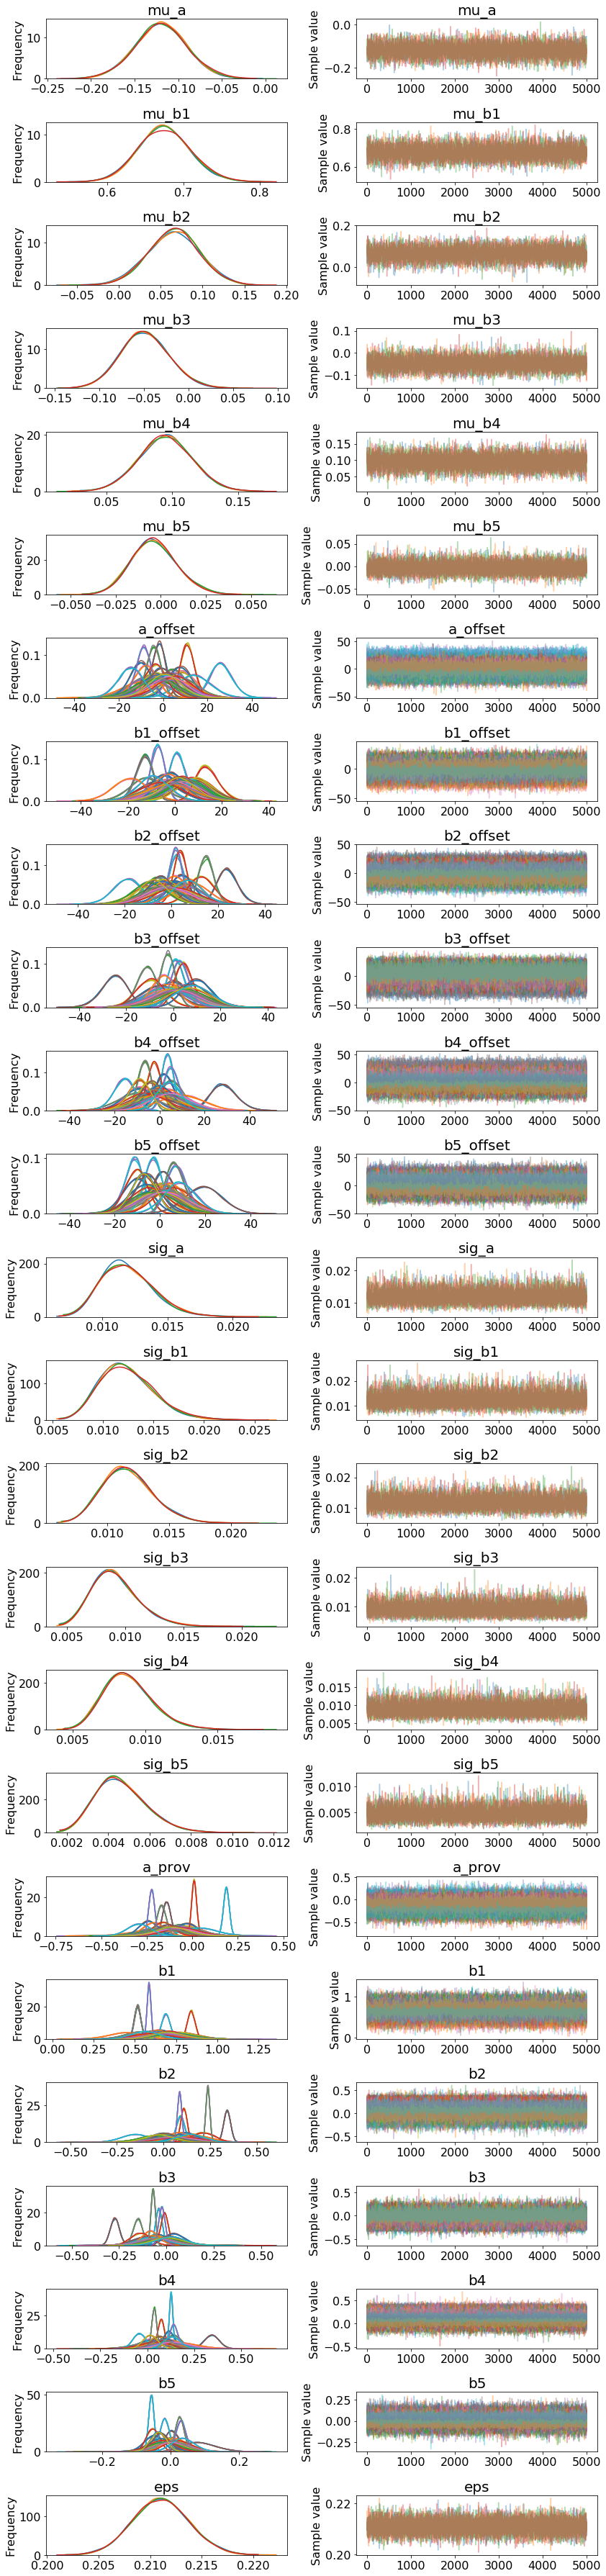

In [283]:
pm.traceplot(trace_m5ve);

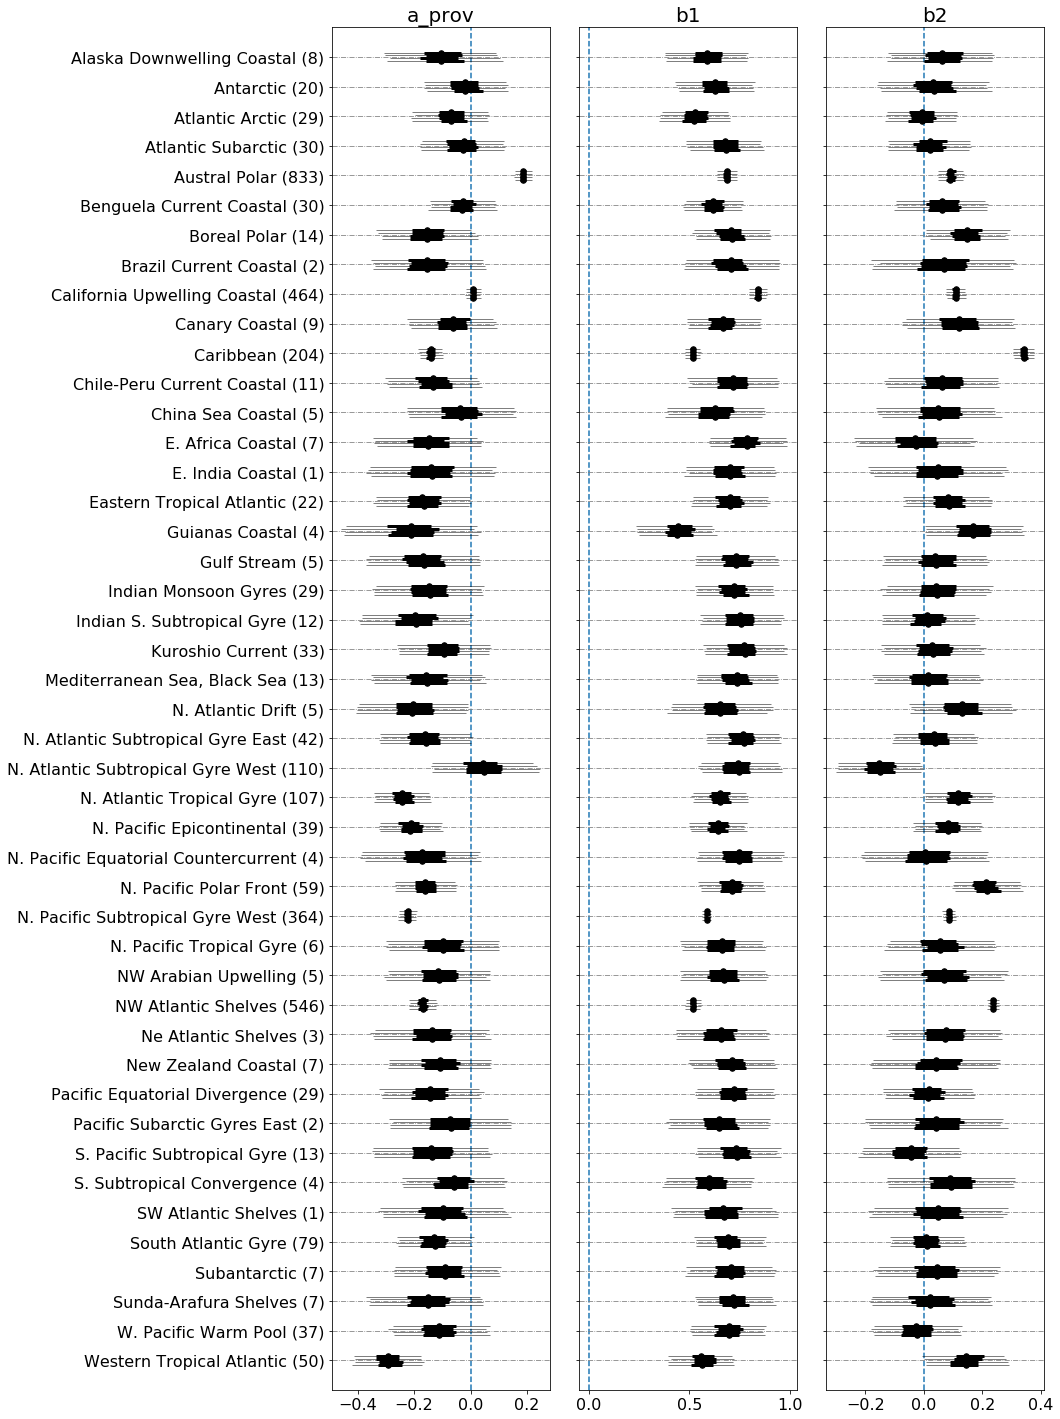

In [267]:
modified_forest_plot(trace_m5ve, varnames=['a_prov', 'b1', 'b2'], group_idcs=s_providx)

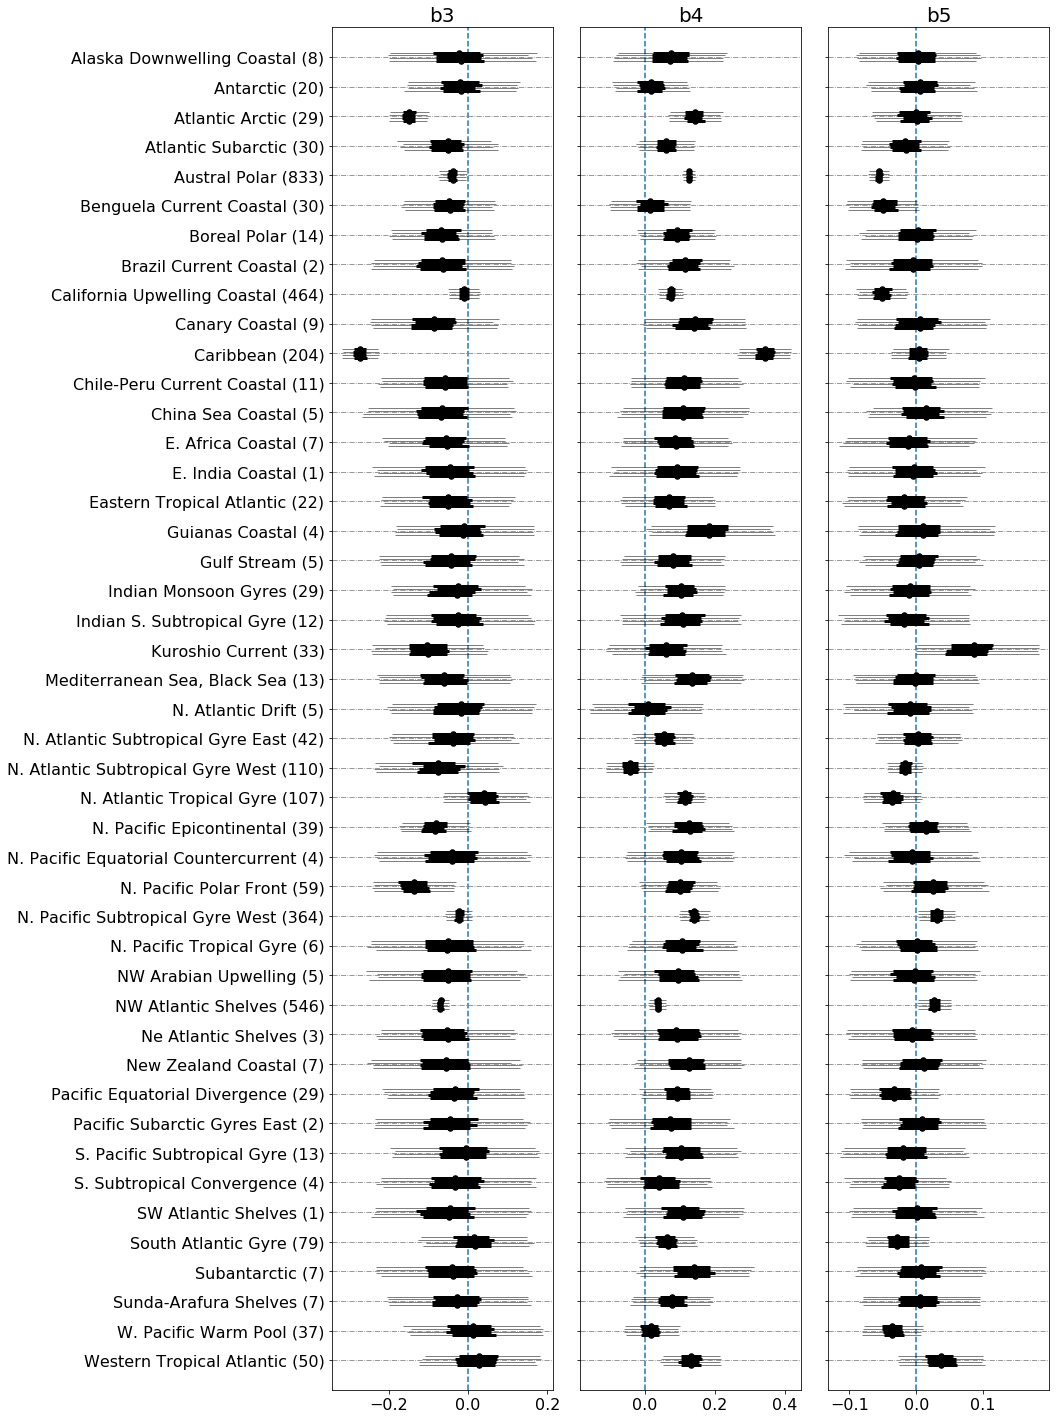

In [284]:
modified_forest_plot(trace_m5ve, varnames=['b3', 'b4', 'b5'], group_idcs=s_providx)

In [402]:
with pm.Model() as m6ve:
    """Hierarchical MLR with varying slope"""
    # hyperpriors
    
    mu_a = pm.Normal('mu_a', 0, sd=100)
    mu_b1 = pm.Normal('mu_b1', 0, sd=100)
    mu_b2 = pm.Normal('mu_b2', 0, sd=100)
    mu_b3 = pm.Normal('mu_b3', 0, sd=100)
    mu_b4 = pm.Normal('mu_b4', 0, sd=100)
    mu_b5 = pm.Normal('mu_b5', 0, sd=100)
    mu_b6 = pm.Normal('mu_b6', 0, sd=100)
    sig_a = pm.HalfCauchy('sig_a', 2.5)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    sig_b4 = pm.HalfCauchy('sig_b4', 2.5)
    sig_b5 = pm.HalfCauchy('sig_b5', 2.5)
    sig_b6 = pm.HalfCauchy('sig_b6', 2.5)
    
    a_offset = pm.Normal('a_offset', mu=0, sd=10, shape=n_provinces)
    b1_offset = pm.Normal('b1_offset', mu=0, sd=10, shape=n_provinces)
    b2_offset = pm.Normal('b2_offset', mu=0, sd=10, shape=n_provinces)
    b3_offset = pm.Normal('b3_offset', mu=0, sd=10, shape=n_provinces)
    b4_offset = pm.Normal('b4_offset', mu=0, sd=10, shape=n_provinces)
    b5_offset = pm.Normal('b5_offset', mu=0, sd=10, shape=n_provinces)
    b6_offset = pm.Normal('b6_offset', mu=0, sd=10, shape=n_provinces)
    
    a_prov = pm.Deterministic('a_prov', mu_a + a_offset * sig_a)
    b1 = pm.Deterministic('b1', mu_b1 + b1_offset * sig_b1)
    b2 = pm.Deterministic('b2', mu_b2 + b2_offset * sig_b2)
    b3 = pm.Deterministic('b3', mu_b3 + b3_offset * sig_b3)
    b4 = pm.Deterministic('b4', mu_b4 + b4_offset * sig_b4)
    b5 = pm.Deterministic('b5', mu_b5 + b5_offset * sig_b5)
    b6 = pm.Deterministic('b6', mu_b6 + b6_offset * sig_b6)
    
    #a_prov = pm.Normal('a_prov', mu=mu_a, sd=sig_a)
    #b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    #b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    #b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    #b4 = pm.Normal('b4', mu=mu_b4, sd=sig_b4, shape=n_provinces)
    #b5 = pm.Normal('b5', mu=mu_b5, sd=sig_b5, shape=n_provinces)
    #b6 = pm.Normal('b6', mu=mu_b6, sd=sig_b6, shape=n_provinces)
    mu_log_chl = pm.Deterministic('mu_log_chl',
                                 a_prov[provIdx] + b1[provIdx] * x_pc_s[0] \
                                 + b2[provIdx] * x_pc_s[1] \
                                 + b3[provIdx] * x_pc_s[2] \
                                 + b4[provIdx] * x_pc_s[3] \
                                 + b5[provIdx] * x_pc_s[4] \
                                 + b6[provIdx] * x_pc_s[5] )
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m6ve = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b6_offset, b5_offset, b4_offset, b3_offset, b2_offset, b1_offset, a_offset, sig_b6_log__, sig_b5_log__, sig_b4_log__, sig_b3_log__, sig_b2_log__, sig_b1_log__, sig_a_log__, mu_b6, mu_b5, mu_b4, mu_b3, mu_b2, mu_b1, mu_a]
  1%|          | 67/10000 [00:09<24:34,  6.74it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [08:03<00:00, 20.70it/s]


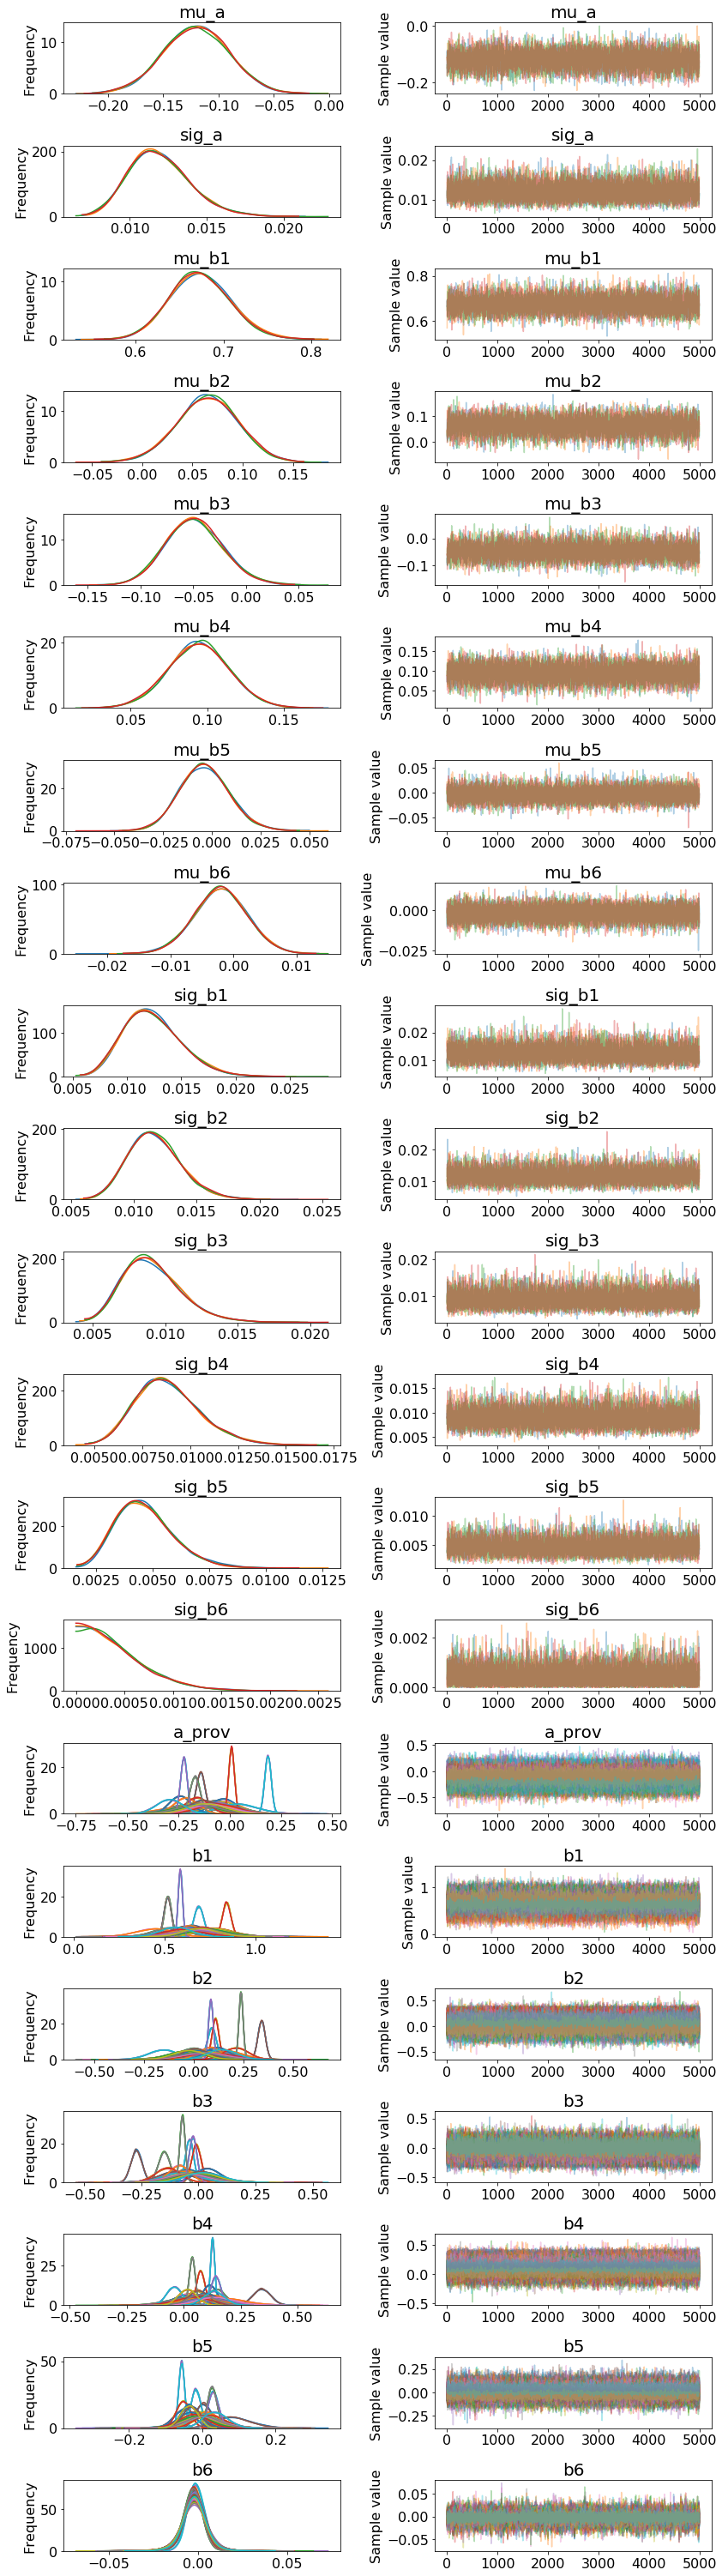

In [274]:
pm.traceplot(trace_m6ve, varnames=['mu_a', 'sig_a'] + ['mu_b%d' %i for i in range(1, 7)]
            + ['sig_b%d' % i for i in range(1, 7)] + ['a_prov'] 
            + ['b%d' %i for i in range(1, 7)]);

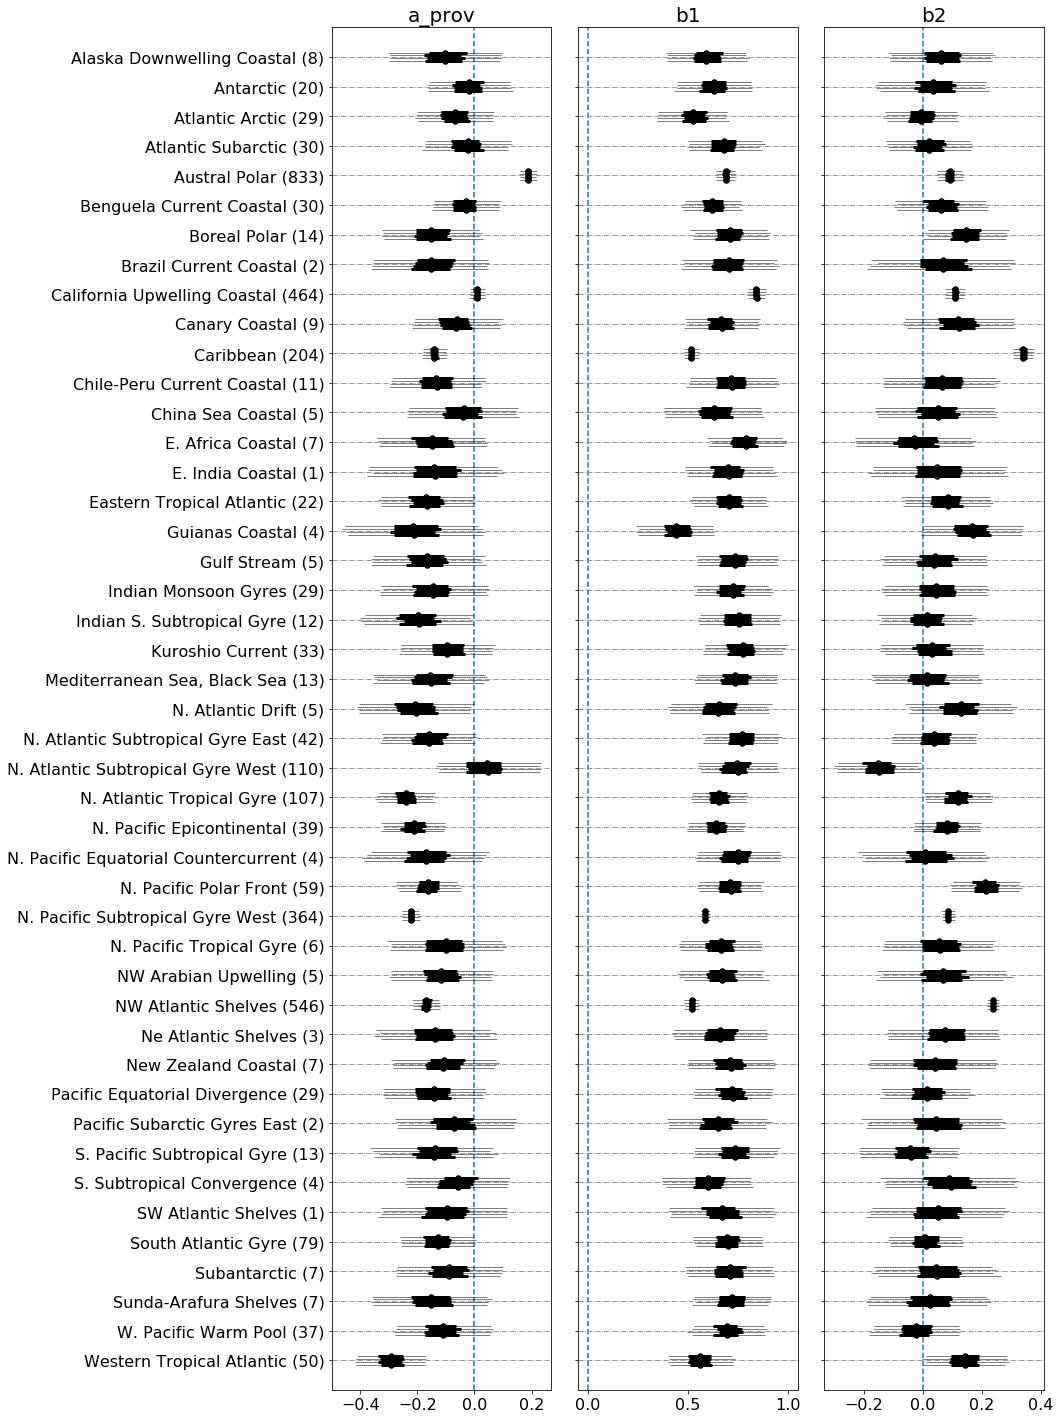

In [416]:
modified_forest_plot(trace_m6ve, varnames=['a_prov', 'b1', 'b2'], group_idcs=s_providx)

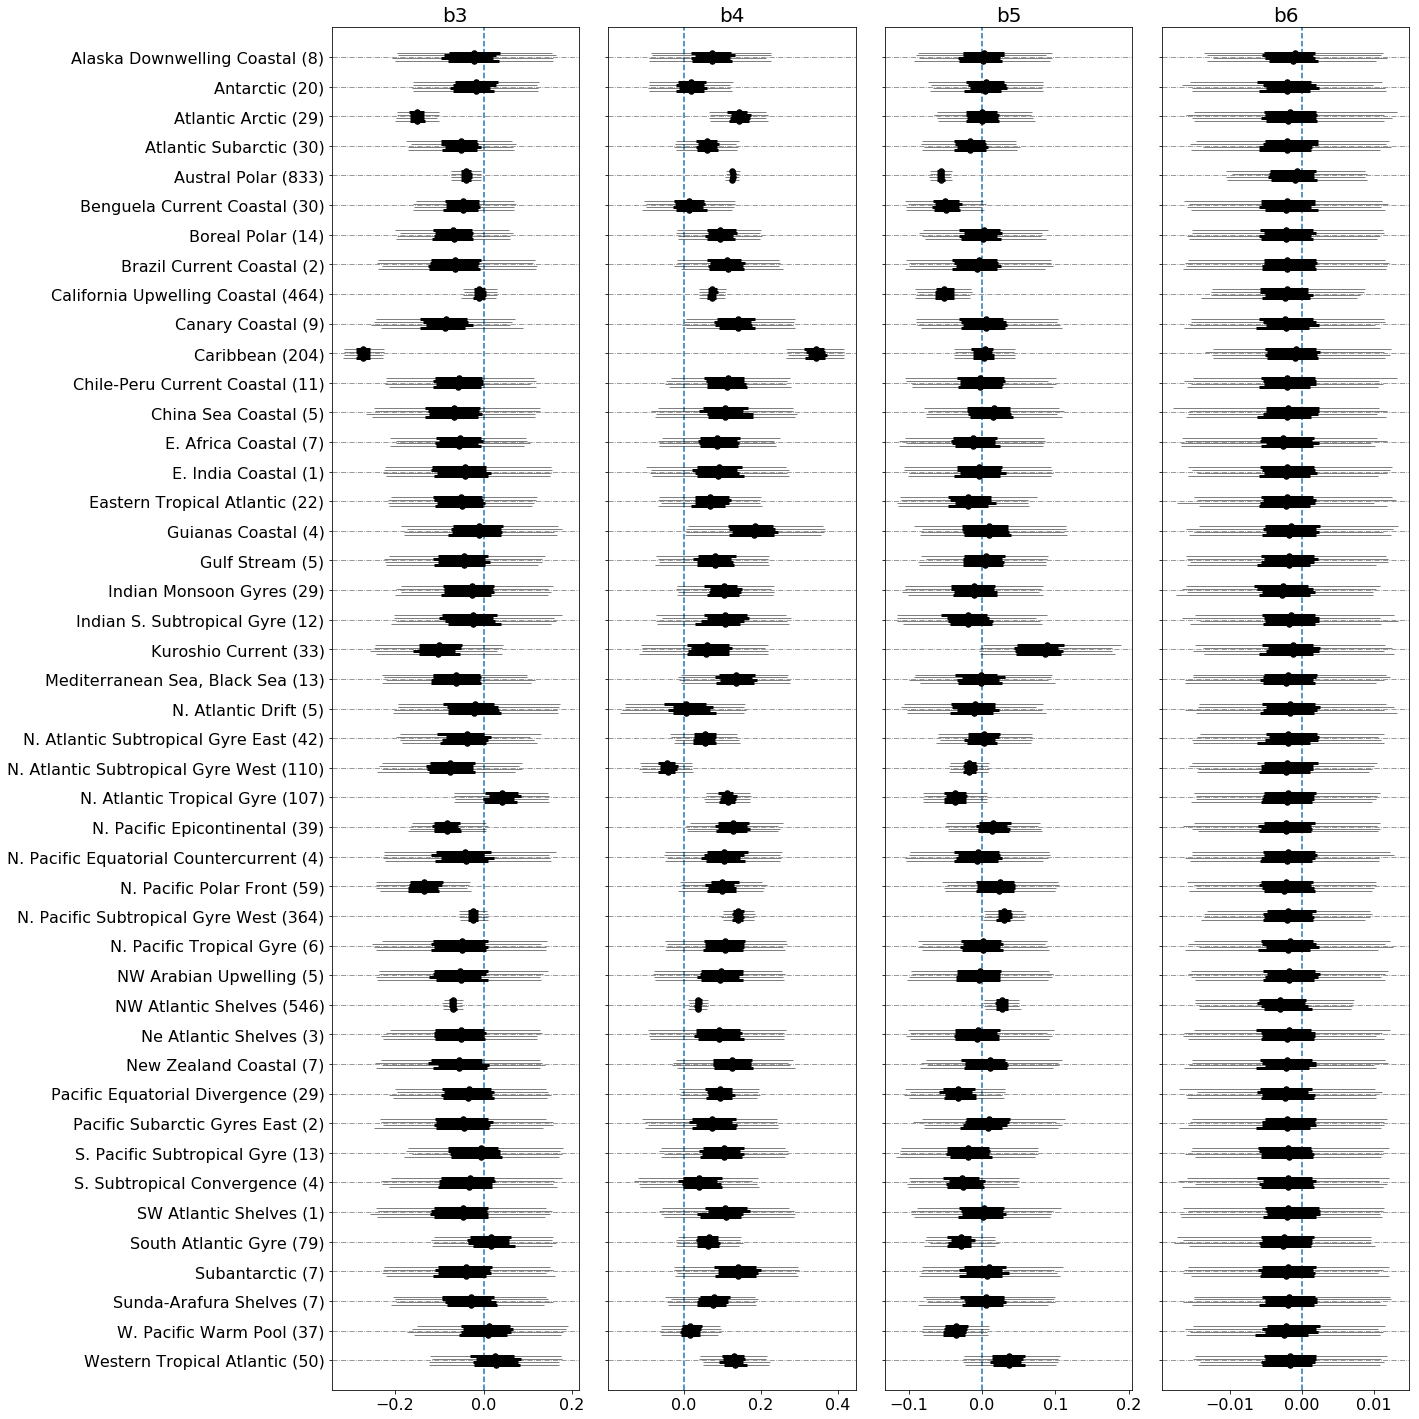

In [279]:
modified_forest_plot(trace_m6, varnames=['b3', 'b4', 'b5', 'b6'], group_idcs=s_providx)

In [417]:
mdl_dict = dict(m1=dict(trace=trace_m1ve, model=m1ve), 
                m2=dict(trace=trace_m2ve, model=m2ve), 
                m3=dict(trace=trace_m3ve, model=m3ve),
                m4=dict(trace=trace_m4ve, model=m4ve),
                m5=dict(trace=trace_m5ve, model=m5ve),
                m6=dict(trace=trace_m6ve, model=m6ve)
               )
with open('./pickleJar/pc_models.pkl', 'wb') as f:
    pickle.dump(mdl_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [288]:
ppc_dict = {}
ppc_dict['m1'] = pm.sample_ppc(trace_m1ve, samples=1000, model=m1ve)['log_chl']
ppc_dict['m2'] = pm.sample_ppc(trace_m2ve, samples=1000, model=m2ve)['log_chl']
ppc_dict['m3'] = pm.sample_ppc(trace_m3ve, samples=1000, model=m3ve)['log_chl']
ppc_dict['m4'] = pm.sample_ppc(trace_m4ve, samples=1000, model=m4ve)['log_chl']
ppc_dict['m5'] = pm.sample_ppc(trace_m5ve, samples=1000, model=m5ve)['log_chl']
ppc_dict['m6'] = pm.sample_ppc(trace_m6ve, samples=1000, model=m6ve)['log_chl']

100%|██████████| 1000/1000 [00:01<00:00, 863.18it/s]


In [397]:
def get_model_predictions(trace_matrix, obs):
    "obs are the input, arranged row-wise"
    mdl_prediction = trace_matrix[:, 0] + np.dot(trace_matrix, obs) 
    return mdl_prediction

In [ ]:
mdl_pred_1 = get_model_predictions(trace_matrix=)

In [400]:
np.c_[trace_m1ve.get_values('a_prov')].shape

(20000, 45)

In [401]:
ppc_dict['m1'].shape

(1000, 3311)

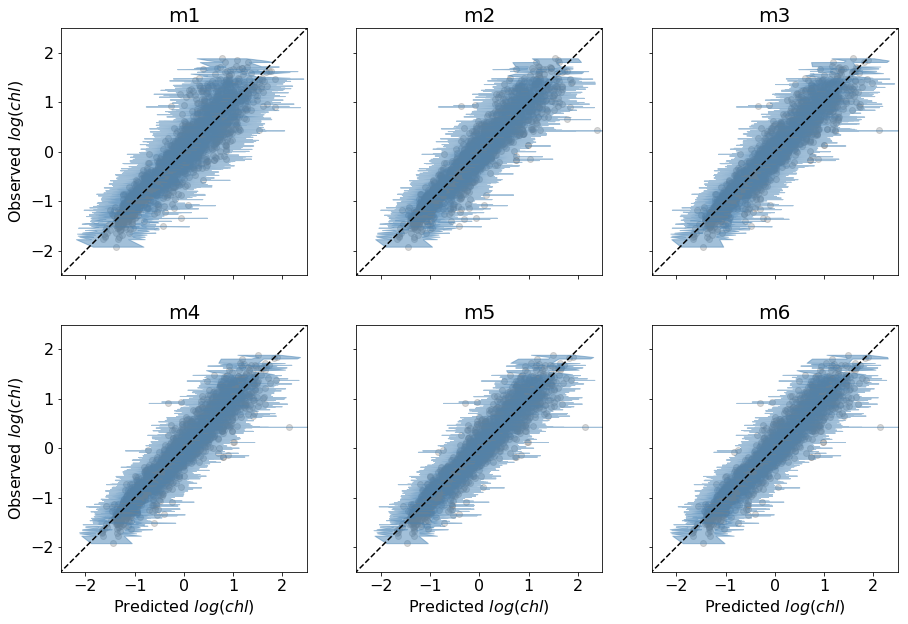

In [395]:
ncols = 3
f, axs = pl.subplots(ncols=ncols, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axs.ravel()
iy = np.argsort(log_chl_obs)
ax_counter = 0
for axi, (key, val) in zip(ax, ppc_dict.items()):
    
    mean = val.mean(axis=0)
    hpd = pm.hpd(val)
    axi.scatter(mean[iy], log_chl_obs[iy], color='gray', alpha=0.3)
    axi.fill_betweenx(log_chl_obs[iy], hpd[iy, 0], hpd[iy, 1], alpha=0.5,
                      color='steelblue')
    #axi.plot(hpd[iy, 0], mean[iy], ls=':')
    #axi.plot(hpd[iy, 1], mean[iy], ls=':')
    axi.set_title(key)
    axi.set_xlim((-2.5, 2.5))
    axi.set_ylim((-2.5, 2.5))
    axi.plot([-3, 3], [-3, 3], ls='--', color='k')
    if ax_counter >= ncols:
        axi.set_xlabel('Predicted $log(chl)$')
    if ax_counter % ncols == 0:
        axi.set_ylabel('Observed $log(chl$)')
    ax_counter += 1

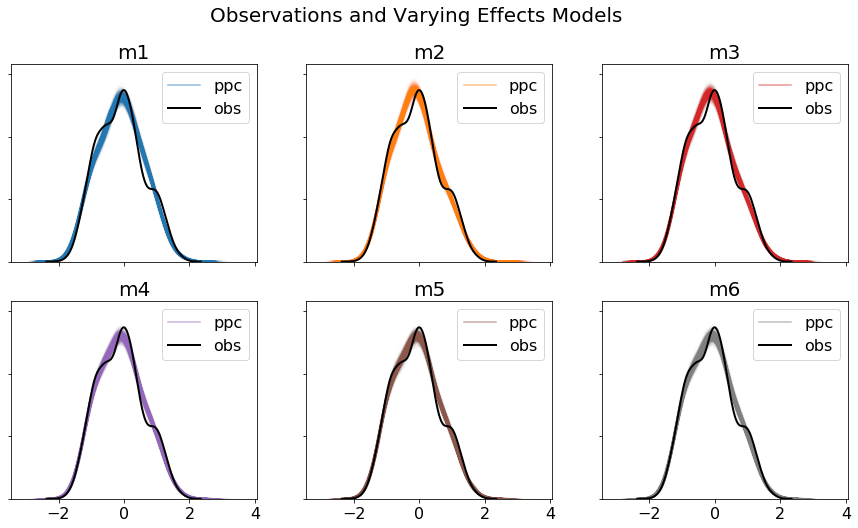

In [313]:
f, axs = pl.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)
ax = axs.ravel()
cm_ = cm.get_cmap('tab10')
cmh = [rgb2hex(cm_(i)[:3]) for i in [0, 1, 3, 4, 5, 7]]
for axi, (key, val), col_hex in zip(ax, ppc_dict.items(), cmh):
    axi.set_yticklabels([])
    axi.set_title(key)
    for i in range(val.shape[0]):
        if i == 0:
            kdeplot(val[i], color=col_hex, alpha=0.5, ax=axi, label='ppc')
        else:
            kdeplot(val[i], color=col_hex, alpha=0.01, ax=axi)

    kdeplot(log_chl_obs, ax=axi, linewidth=2, color='k', label='obs')
f.suptitle('Observations and Varying Effects Models', fontsize=20)
f.savefig('./figJar/kdeDensCompVE.png', dpi=300, format='png')

In [316]:
m1ve.name=  'm1: {pc1}'
m2ve.name = 'm2: {pc1, pc2}'
m3ve.name = 'm3: {pc1 ... 3}'
m4ve.name = 'm4: {pc1 ... 4}'
m5ve.name = 'm5: {pc1 ... 5}'
m6ve.name = 'm6: {pc1 ... 6}'

In [317]:
dfcomp = pm.compare({m1ve: trace_m1ve, m2ve: trace_m2ve, m3ve: trace_m3ve,
                    m4ve: trace_m4ve, m5ve: trace_m5ve, m6ve: trace_m6ve})
dfcomp

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC   pWAIC    dWAIC weight      SE     dSE var_warn
m5: {pc1 ... 5} -780.08  115.63        0   0.91  138.51       0        1
m6: {pc1 ... 6} -775.84   117.9     4.24      0  138.46    1.19        1
m4: {pc1 ... 4} -708.01  100.38    72.07      0  134.14   24.34        1
m3: {pc1 ... 3} -367.55   82.51   412.53   0.02  133.22    53.9        1
m2: {pc1, pc2}  -155.55   71.55   624.53      0   142.3    66.9        1
m1: {pc1}        670.95      39  1451.03   0.06  121.63  114.49        1

In [318]:
dfcomp_loo = pm.compare({m1ve: trace_m1ve, m2ve: trace_m2ve, m3ve: trace_m3ve,
                        m4ve: trace_m4ve, m5ve: trace_m5ve, m6ve: trace_m6ve},
                        ic='LOO')
dfcomp_loo

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO    pLOO     dLOO weight      SE     dSE shape_warn
m5: {pc1 ... 5} -773.56  118.89        0   0.91  138.58       0          1
m6: {pc1 ... 6} -768.65   121.5     4.91      0  138.54    1.23          1
m4: {pc1 ... 4} -703.31  102.73    70.25      0  133.95    24.4          1
m3: {pc1 ... 3} -364.88   83.85   408.69   0.02  133.12   53.97          1
m2: {pc1, pc2}   -151.9   73.37   621.66      0  142.68   67.17          1
m1: {pc1}        671.97   39.51  1445.53   0.06  121.64  114.46          0

In [367]:
with open('./pickleJar/GaussianModels_single_cluster.pkl', 'rb') as f:
    non_pc_mdls_dict = pickle.load(f)

In [385]:
non_pc_mdls_dict['data'].shape

(4126, 21)

In [374]:
for val in non_pc_mdls_dict.values():
    print(val)

{'mdl': <pymc3.model.Model object at 0x7f21edf1f8d0>, 'trc': <MultiTrace: 4 chains, 5000 iterations, 4 variables>}
{'mdl': <pymc3.model.Model object at 0x7f220694f5f8>, 'trc': <MultiTrace: 4 chains, 5000 iterations, 10 variables>}
{'mdl': <pymc3.model.Model object at 0x7f21e3839470>, 'trc': <MultiTrace: 4 chains, 5000 iterations, 10 variables>}
{'mdl': <pymc3.model.Model object at 0x7f21e2452da0>, 'trc': <MultiTrace: 4 chains, 5000 iterations, 10 variables>}
{'mdl': <pymc3.model.Model object at 0x7f21e1103208>, 'trc': <MultiTrace: 4 chains, 5000 iterations, 11 variables>}
      mxBlId  provCat  mxBlCat  biomCat   MxBl-Gr  oisst  etopo2_l       chl  \
0     rrs510        0        2        0 -0.025710  13.04  1.913814  2.077000   
1     rrs510        0        2        0 -0.024278  11.74  1.146128  1.799000   
2     rrs510        0        2        0 -0.020502  11.74  2.029384  1.608000   
3     rrs510        0        2        0  0.039941   9.71  2.155336  1.579000   
4     rrs489        0

In [377]:
current_models_dict = {m1ve: trace_m1ve, m2ve: trace_m2ve, m3ve: trace_m3ve,
                    m4ve: trace_m4ve, m5ve: trace_m5ve, m6ve: trace_m6ve}
single_predictor_models = {val['mdl']: val['trc'] for k, val in non_pc_mdls_dict.items()
                          if k != 'data'}

In [378]:
current_models_dict

{<pymc3.model.Model at 0x7f2218327278>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f2205e82e80>: <MultiTrace: 4 chains, 5000 iterations, 14 variables>,
 <pymc3.model.Model at 0x7f220c6c9c88>: <MultiTrace: 4 chains, 5000 iterations, 18 variables>,
 <pymc3.model.Model at 0x7f2206405f28>: <MultiTrace: 4 chains, 5000 iterations, 27 variables>,
 <pymc3.model.Model at 0x7f21fc387ba8>: <MultiTrace: 4 chains, 5000 iterations, 32 variables>,
 <pymc3.model.Model at 0x7f21edbf1a90>: <MultiTrace: 4 chains, 5000 iterations, 37 variables>}

In [379]:
single_predictor_models

{<pymc3.model.Model at 0x7f21edf1f8d0>: <MultiTrace: 4 chains, 5000 iterations, 4 variables>,
 <pymc3.model.Model at 0x7f220694f5f8>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f21e3839470>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f21e2452da0>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f21e1103208>: <MultiTrace: 4 chains, 5000 iterations, 11 variables>}

In [382]:
merged_model_dict = {}
merged_model_dict.update(current_models_dict)
merged_model_dict.update(single_predictor_models)

In [383]:
merged_model_dict

{<pymc3.model.Model at 0x7f2218327278>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f2205e82e80>: <MultiTrace: 4 chains, 5000 iterations, 14 variables>,
 <pymc3.model.Model at 0x7f220c6c9c88>: <MultiTrace: 4 chains, 5000 iterations, 18 variables>,
 <pymc3.model.Model at 0x7f2206405f28>: <MultiTrace: 4 chains, 5000 iterations, 27 variables>,
 <pymc3.model.Model at 0x7f21fc387ba8>: <MultiTrace: 4 chains, 5000 iterations, 32 variables>,
 <pymc3.model.Model at 0x7f21edbf1a90>: <MultiTrace: 4 chains, 5000 iterations, 37 variables>,
 <pymc3.model.Model at 0x7f21edf1f8d0>: <MultiTrace: 4 chains, 5000 iterations, 4 variables>,
 <pymc3.model.Model at 0x7f220694f5f8>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f21e3839470>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f21e2452da0>: <MultiTrace: 4 chains, 5000 iterations, 10 variables>,
 <pymc3.model.Model at 0x7f21e1103208>: <MultiTrace

In [384]:
dcomp_all = pm.compare(merged_model_dict)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


ValueError: The number of observations should be the same across all models

In [ ]:
dcomp_all_loo = pm.compare(merged_model_dict)

In [322]:
loo_m5ve = pm.loo(trace_m5ve, model=m5ve, pointwise=True)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


In [329]:
loo_m1ve = pm.loo(trace_m1ve, model=m1ve, pointwise=True, progressbar=True)

20000it [00:01, 10057.35it/s]


In [336]:
cmap =cmo.balance(provIdx)[:, :3]

In [ ]:
pm.l

In [337]:
cmap.shape

(3311, 3)

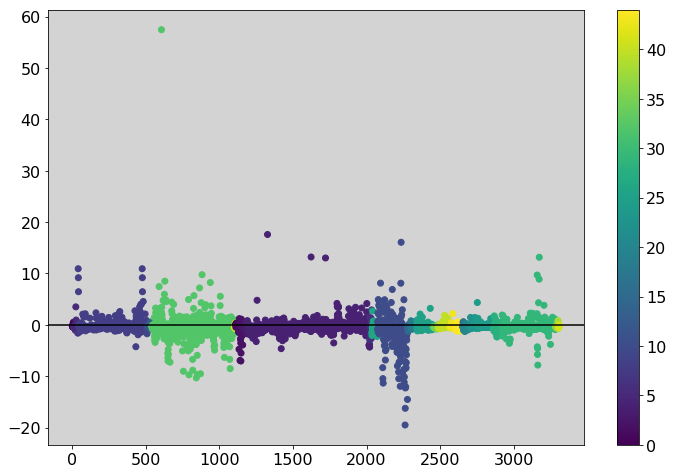

In [366]:
f, ax = pl.subplots(figsize=(12, 8))
ax.set_facecolor('lightgray')
mpbl = ax.scatter(np.arange(3311), loo_m5ve.LOO_i - loo_m1ve.LOO_i,
           c=provIdx, cmap='viridis')
ax.axhline(color='k')
pl.colorbar(mpbl);

Modification to Province strings

In [109]:

df_pca_bn.Province.replace('Boreal Polar Province (Polr)', 'Boreal Polar Province',
                           inplace=True)
df_pca_bn.Province.replace('Canary Coastal Province (Eacb)',
                           'Canary Coastal Province', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Drift Province (Wwdr)', 
                           'N. Atlantic Drift Province', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Subtropical Gyral Province (East) (Stge)',
                          'N. Atlantic Subtropical Gyral Province East', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Subtropical Gyral Province (West) (Stgw)',
                          'N. Atlantic Subtropical Gyral Province West', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Tropical Gyral Province (Trpg)',
                          'N. Atlantic Tropical Gyral Province', inplace=True)
df_pca_bn.Province.replace('N. Pacific Subtropical Gyre Province (West)', 
                          'N. Pacific Subtropical Gyre Province West', inplace=True)
df_pca_bn.Province.replace('Pacific Subarctic Gyres Province (East)', 
                          'Pacific Subarctic Gyres Province East', inplace=True)
df_pca_bn.Province.replace('South Atlantic Gyral Province (Satg)', 
                           'South Atlantic Gyral Province', inplace=True)

df_pca_bn.Province = df_pca_bn.Province.str.replace(' Province', '')

provcode = df_pca_bn.apply(lambda x: "".join(pat.findall(x['Province'])), axis=1)
df_pca_bn.insert(df_pca_bn.columns.get_loc('Province'), 
                'ProvCode', provcode)

province_names = df_pca_bn.Province.unique()

array(['Alaska Downwelling Coastal', 'Benguela Current Coastal',
       'Brazil Current Coastal', 'California Upwelling Coastal',
       'Canary Coastal', 'Chile-Peru Current Coastal',
       'China Sea Coastal', 'E. Africa Coastal', 'E. India Coastal',
       'Guianas Coastal', 'Ne Atlantic Shelves', 'New Zealand Coastal',
       'NW Arabian Upwelling', 'NW Atlantic Shelves',
       'Sunda-Arafura Shelves', 'SW Atlantic Shelves', 'Antarctic',
       'Atlantic Arctic', 'Atlantic Subarctic', 'Austral Polar',
       'Boreal Polar', 'N. Pacific Epicontinental', 'Caribbean',
       'Eastern Tropical Atlantic', 'Indian Monsoon Gyres',
       'Indian S. Subtropical Gyre', 'N. Atlantic Tropical Gyral',
       'N. Pacific Equatorial Countercurrent', 'N. Pacific Tropical Gyre',
       'Pacific Equatorial Divergence', 'South Atlantic Gyral',
       'W. Pacific Warm Pool', 'Western Tropical Atlantic', 'Gulf Stream',
       'Kuroshio Current', 'Mediterranean Sea, Black Sea',
       'N. Atlantic Dr

In [108]:
pat = re.compile(r'([A-Z]{1}[a-z])')

45

In [288]:
def shorten_string(prov_str):
    prov_str_lst = prov_str.split(' ')
    if len(prov_str_lst) == 1:
        ttl_str = prov_str_lst[0]
    else:
        new_lst = []
        for word in prov_str_lst:
            if len(word)>4:
                word = word[:4] + '.'
            new_lst.append(word)
        ttl_str = " ".join(new_lst)
    return ttl_str


def compute_mdl_mean(trace, i, df_):
    b = np.c_[trace['b1'][:, i].mean(), trace['b2'][:, i].mean(),
              trace['b3'][:, i].mean(), trace['b4'][:, i].mean(),
              trace['b5'][:, i].mean(), trace['b6'][:, i].mean()]
    mu_ = b.dot(df_.loc[df_.ProvIdx==i,
                        ['PC%d' %j for j in range(1, 7)]
                       ].as_matrix().T)
    return mu_.flatten()

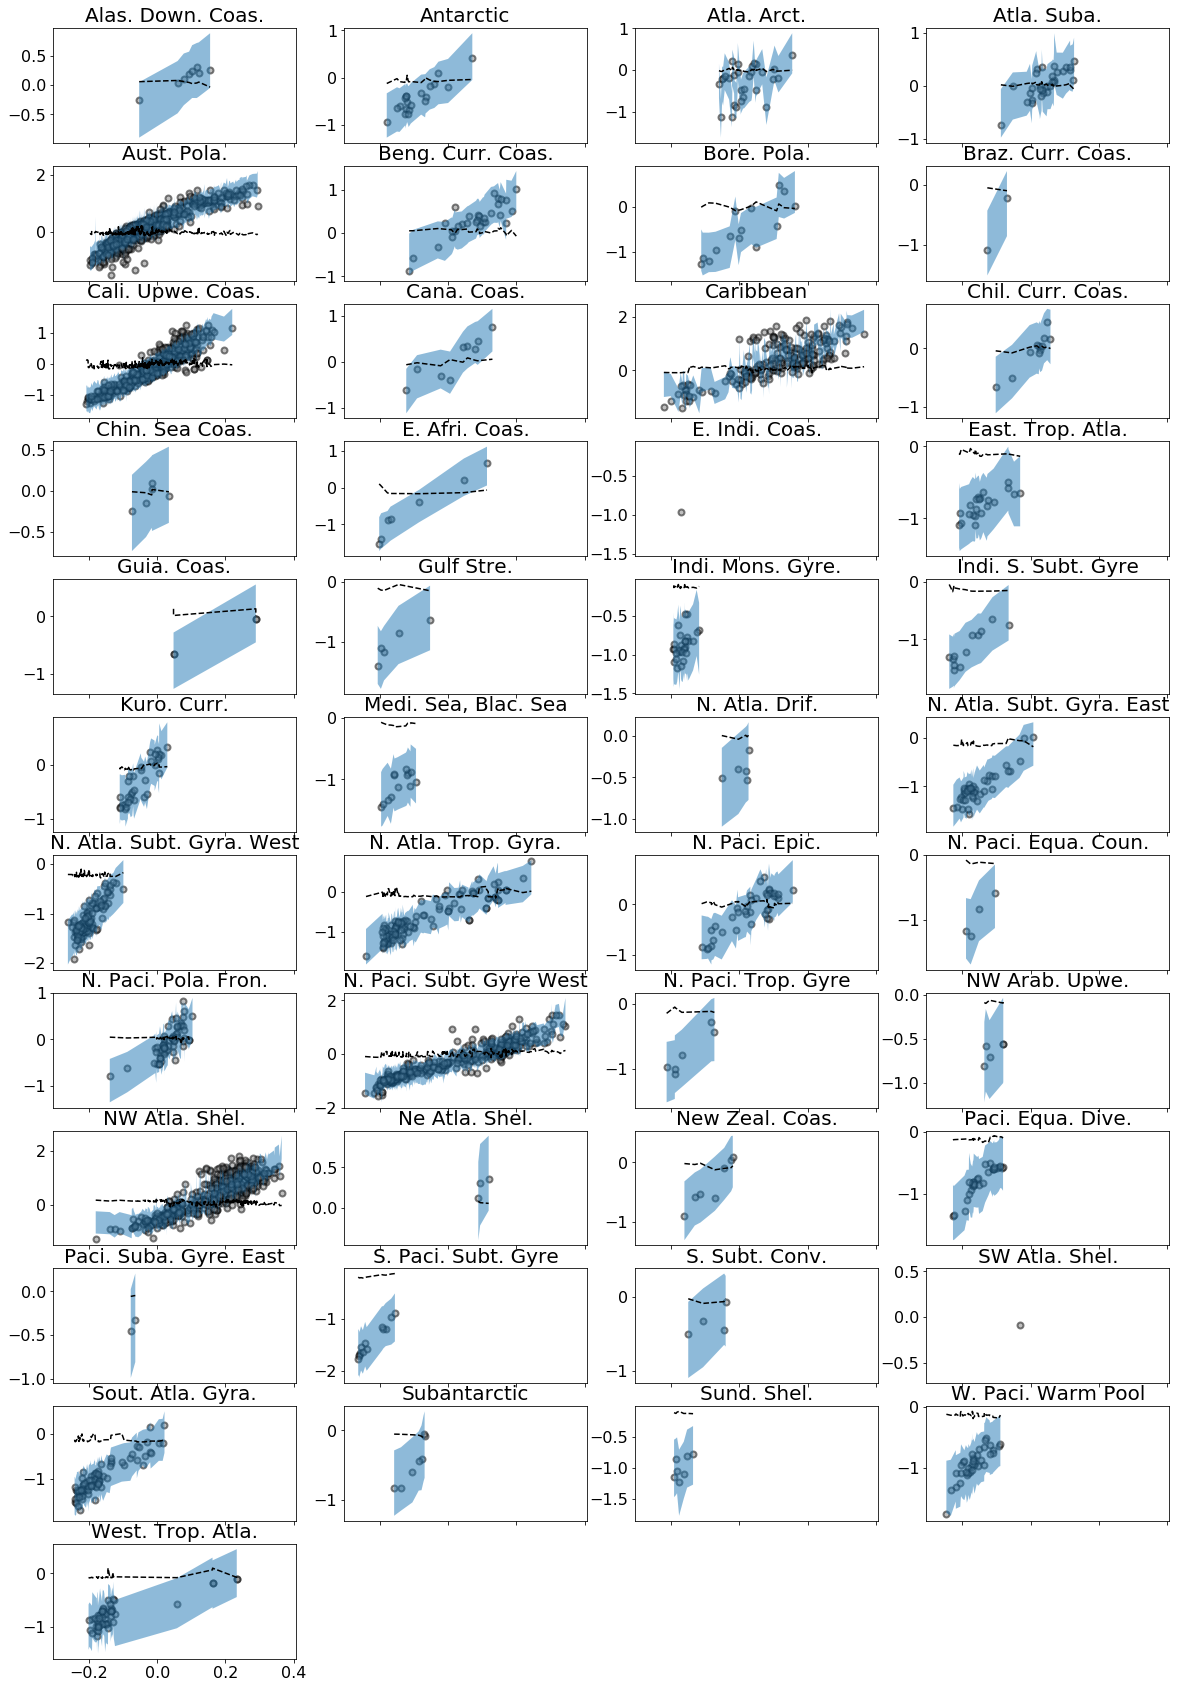

In [289]:
_, axs = pl.subplots(nrows=12, ncols=4, figsize=(20, 30), sharex=True)
ax = axs.ravel()
for i, prov in prov_mapping.items():
    xy = d_.loc[d_.ProvIdx==i, ['PC1', 'pred_chl_l_mean',
                                'pred_chl_l_95lo', 
                                'pred_chl_l_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                  alpha=0.5, linewidth=2)
    title_string = shorten_string(prov)
    ax[i].set_title(title_string)
    mu_ = compute_mdl_mean(trace_m0, i, df_pca_bn)
    ax[i].plot(xy[ix, 0], mu_, 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)
ax[45].set_visible(False)
ax[46].set_visible(False)
ax[47].set_visible(False)